### Setup 

This is just the basic stuff to get things to work

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
from chainedMorpher import *

cpu


In [2]:
class DataSet(Dataset):
    def __init__(self, samples, labels):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y

In [3]:
class simple_MLP_onelayer(torch.nn.Module):
    def __init__(self,in_data,input_size,out_channels=1,act_out=False,nhidden=64,batchnorm=False,batch_size=250,n_epochs=35):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, out_channels),
        )
        self.loss    = nn.BCELoss()
        self.output  = torch.nn.Sigmoid()
        self.act_out = act_out
        self.batch_size = batch_size
        self.n_epochs     = n_epochs
        self.opt     = torch.optim.Adam(self.model.parameters(),lr=0.0002)
        self.dataloader = DataLoader(in_data, batch_size=self.batch_size)#,pin_memory=True)
        
    def forward(self, x):
        x = self.model(x)        
        if self.act_out:
            x = self.output(x)
        return x
    
    def training_mse_epoch(self):
        running_loss = 0.0
        updates=0
        for batch_idx, (x, y) in enumerate(self.dataloader):
            self.opt.zero_grad()
            #x     = x.cuda(); y = y.cuda()
            x_out = self.forward(x)
            loss  = self.loss(x_out.flatten(), y.flatten())
            loss.backward()
            self.opt.step()
            running_loss += loss 
            updates = updates+1
        return running_loss/updates

    def training_mse(self):
        for epoch in range(self.n_epochs):
            self.model.train(True)
            loss_train = self.training_mse_epoch()
            #self.model2.train(False)
            #loss_valid = self.validate_mse_epoch(self.model2,self.val_dataloader_mse())
            print('Epoch: {} LOSS train: {} '.format(epoch,loss_train))



## Test 1 : A Gaussian that is shifted

Here we take a dataset with 5 dimensions (we have done up to 15), and we just shift one of the dimensions in one of the datasets by 0.5 sigma, then we map one to the other. 

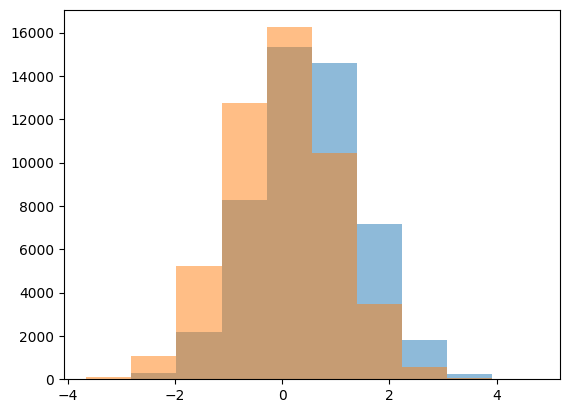

In [5]:
def makeDataSet(iN=50000,iDim=5):
    #1 is going to be called MC
    #2 is going to be called data later on
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v1[:,1] += 0.5
    _,bins,_=plt.hist(v1[:,1],alpha=0.5)
    plt.hist(v2[:,1],bins=bins,alpha=0.5)
    plt.show()
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet()

Now we do the reweighting training and teh apply this to a new dataset.

Epoch: 0 LOSS train: 0.5758138298988342 
Epoch: 1 LOSS train: 0.6731709241867065 
Epoch: 2 LOSS train: 0.6481990218162537 
Epoch: 3 LOSS train: 0.6564878225326538 
Epoch: 4 LOSS train: 0.6648809313774109 
Epoch: 5 LOSS train: 0.6709801554679871 
Epoch: 6 LOSS train: 0.6748383045196533 
Epoch: 7 LOSS train: 0.6766690015792847 
Epoch: 8 LOSS train: 0.6772387027740479 
Epoch: 9 LOSS train: 0.6772430539131165 
Epoch: 10 LOSS train: 0.6769302487373352 
Epoch: 11 LOSS train: 0.6765761375427246 
Epoch: 12 LOSS train: 0.6761829257011414 
Epoch: 13 LOSS train: 0.6758923530578613 
Epoch: 14 LOSS train: 0.6755656599998474 
Epoch: 15 LOSS train: 0.6753243803977966 
Epoch: 16 LOSS train: 0.6750736236572266 
Epoch: 17 LOSS train: 0.6748602986335754 
Epoch: 18 LOSS train: 0.674686074256897 
Epoch: 19 LOSS train: 0.674567699432373 
Epoch: 20 LOSS train: 0.674406886100769 
Epoch: 21 LOSS train: 0.6742897629737854 
Epoch: 22 LOSS train: 0.6741592288017273 
Epoch: 23 LOSS train: 0.6741071939468384 
Epoch

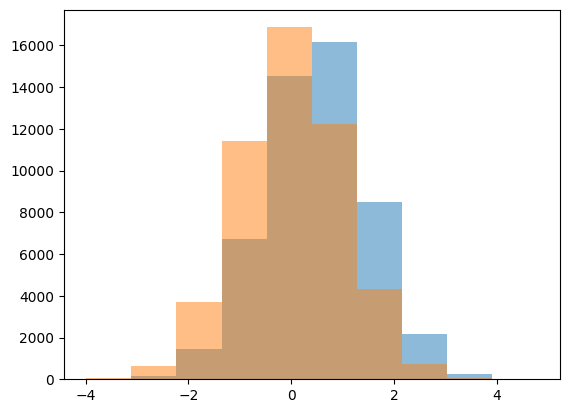

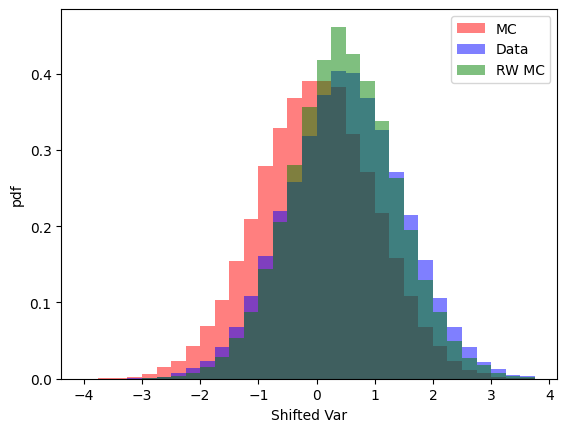

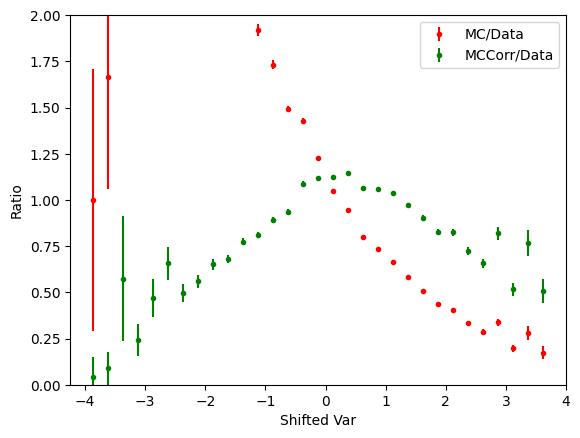

In [6]:
rw_model = simple_MLP_onelayer(data,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()
#
data_test,test_in,label_in=makeDataSet()
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()
#plt.hist(weight[label_in==1],alpha=0.5,bins=np.arange(0.75,2,0.05))
#plt.show()
def ratioComp(iData,iMC,iMCCorr,bin_edge):#
    ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
    ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))
    bincenter = 0.5 * (bin_edge[1:] + bin_edge[:-1])
    plt.errorbar(bincenter, ratio1, yerr=err1, fmt='.', color='r',label='MC/Data')
    plt.errorbar(bincenter, ratio2, yerr=err2, fmt='.', color='g',label='MCCorr/Data')
    plt.ylim(0,2)
    plt.xlabel('Shifted Var')
    plt.ylabel("Ratio")
    plt.legend()
    plt.ylim(0,2.0)
    plt.show()

def weightedComp(iData,iMC,iWeights):
    val1,_,_       =plt.hist(iMC,  alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='r',label='MC')
    val2,_,_       =plt.hist(iData,alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='b',label='Data')
    valc,bin_edge,_=plt.hist(iMC,  alpha=0.5,density=True,bins=np.arange(-4,4,0.25),weights=iWeights,color='g',label='RW MC')
    plt.xlabel('Shifted Var')
    plt.ylabel("pdf")
    plt.legend()
    plt.show()

    val1*=len(iMC)
    val2*=len(iData)
    valc*=len(iMC)
    ratioComp(val2,val1,valc,bin_edge)
    
weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])

Now we train the flows for this

In [53]:
def trainflows(iMC_train,iMC_test,iData_train,iData_test,iNLayers=1,iSeparateScale=False):
    NF_kwargs = {"flow_type":"NSRATQUAD","tail_bound":3.2,"hidden_features":150,
                 "num_layers":iNLayers,"num_bins":20,"num_blocks_per_layer":1,"tails":"linear",
                "dropout":0.0,"residual":True}

    dim=5
    fitvars=[]
    for i0 in range(dim):
        fitvars.append(str(i0))
    rangeScale = 3
    variables = fitvars
    trainer = chainedNFTrainer("NAME_FOR_PROJECT",mc_train,mc_test,data_train,data_test,fitvars,control=[],
                                NF_kwargs=NF_kwargs,rangeScale=rangeScale,separateScale=iSeparateScale)
    bs = 10000
    n_epoch = 10
    n_iter = n_epoch*mc_train.shape[0]//bs
    for i0 in range(dim):
        trainer.trainCurrentBkg(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
        #trainer.plotDensity(bkg=True)
        trainer.trainCurrentData(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
        #trainer.plotDensity(data=True)
        trainer.correctCurrent()
        trainer.stepForward()
    return trainer
    
#alldata_train,train_in,labeltrain_in=makeDataSet()
#alldata_test,test_in,label_in  =makeDataSet()
#mc_train  =train_in[0:50000]
#mc_test   =test_in[0:50000]
#data_train=train_in[50000::]
#data_test =test_in [50000::]
#trainer=trainflows(mc_train,mc_test,data_train,data_test)

Finally we compare the same arios as before, but now with the corrected

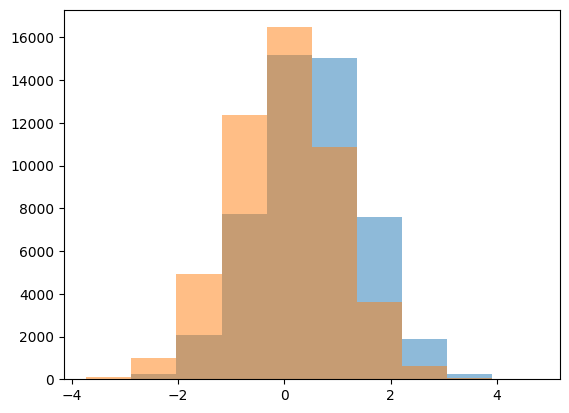

  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:607: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_i = torch.tensor(inputs[i],dtype=torch.float32,device=device)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.65it/s]


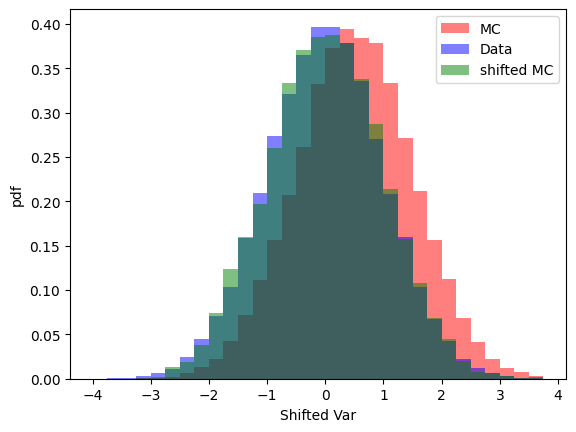

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))


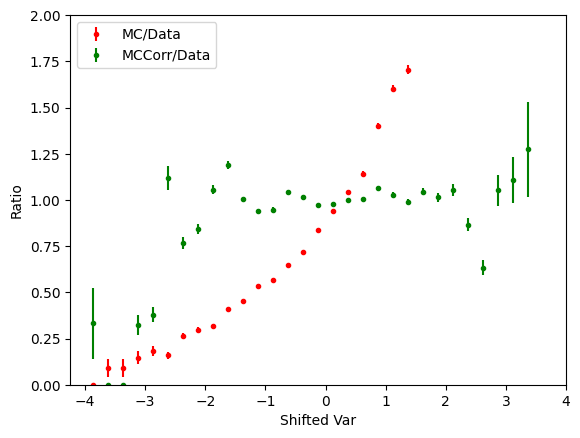

In [8]:
def quantileComp(iData,iMC,iMCCorr):
    val1,_,_       =plt.hist(iMC,    alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='r',label='MC')
    val2,_,_       =plt.hist(iData,  alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='b',label='Data')
    valc,bin_edge,_=plt.hist(iMCCorr,alpha=0.5,density=True,bins=np.arange(-4,4,0.25),color='g',label='shifted MC')
    plt.xlabel('Shifted Var')
    plt.ylabel("pdf")
    plt.legend()
    plt.show()

    val1*=len(iMC)
    val2*=len(iData)
    valc*=len(iMCCorr)
    ratioComp(val2,val1,valc,bin_edge)

alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])



## Test 2 : Adding a strong correlation

Now we are going to take the data and make it such that 

$v_{i} = \mathcal{N}(0,1) \forall i \neq 2$ and 
$v_{2} = \mathcal{N}(0,1) + 5 v_{3}$

This puts a strong correlation in one of the variables, but makes everything else random

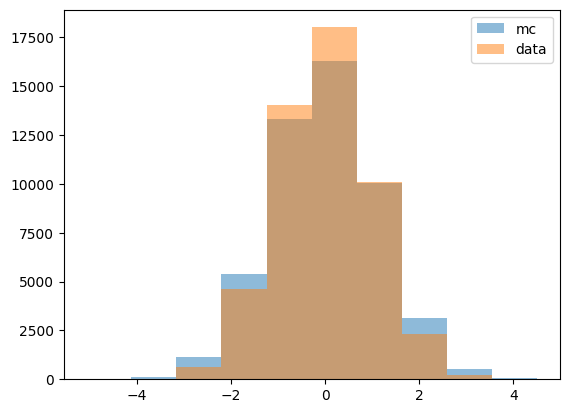

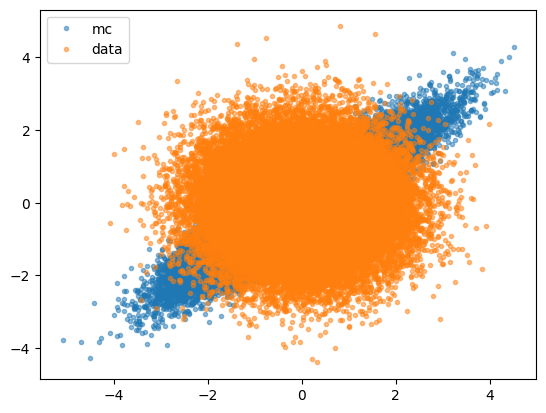

In [54]:
def makeDataSet(iN=50000,iDim=5,iPlot=False):
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v1[:,1] += 2.*v1[:,2]
    v1[:,1] *= 1./2.
    if iPlot:
        _,bins,_=plt.hist(v1[:,1],alpha=0.5,label='mc')
        plt.hist(v2[:,1],bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,1],v1[:,2],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,1],v2[:,2],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet(iPlot=True)

Epoch: 0 LOSS train: 0.5653180480003357 
Epoch: 1 LOSS train: 0.6869522929191589 
Epoch: 2 LOSS train: 0.6227753758430481 
Epoch: 3 LOSS train: 0.5827531218528748 
Epoch: 4 LOSS train: 0.5324559807777405 
Epoch: 5 LOSS train: 0.4886113107204437 
Epoch: 6 LOSS train: 0.43798497319221497 
Epoch: 7 LOSS train: 0.3984872102737427 
Epoch: 8 LOSS train: 0.3663399815559387 
Epoch: 9 LOSS train: 0.34108588099479675 
Epoch: 10 LOSS train: 0.3219190239906311 
Epoch: 11 LOSS train: 0.30771470069885254 
Epoch: 12 LOSS train: 0.29729804396629333 
Epoch: 13 LOSS train: 0.28976383805274963 
Epoch: 14 LOSS train: 0.28438690304756165 
Epoch: 15 LOSS train: 0.2806812524795532 
Epoch: 16 LOSS train: 0.278293639421463 
Epoch: 17 LOSS train: 0.27687469124794006 
Epoch: 18 LOSS train: 0.27621665596961975 
Epoch: 19 LOSS train: 0.27612483501434326 
Epoch: 20 LOSS train: 0.2764028012752533 
Epoch: 21 LOSS train: 0.27696841955184937 
Epoch: 22 LOSS train: 0.27771350741386414 
Epoch: 23 LOSS train: 0.2785325646

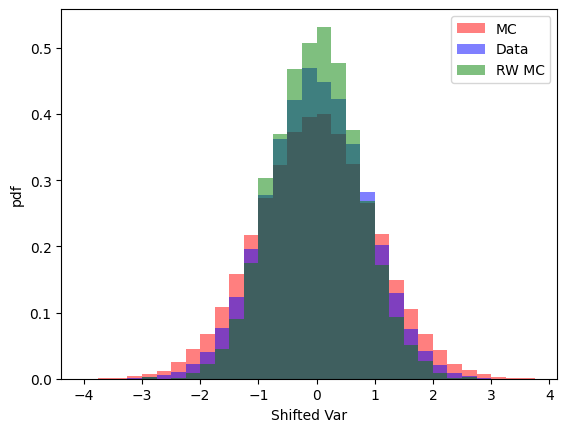

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: divide by zero encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))
/Users/philipharris/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3607: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


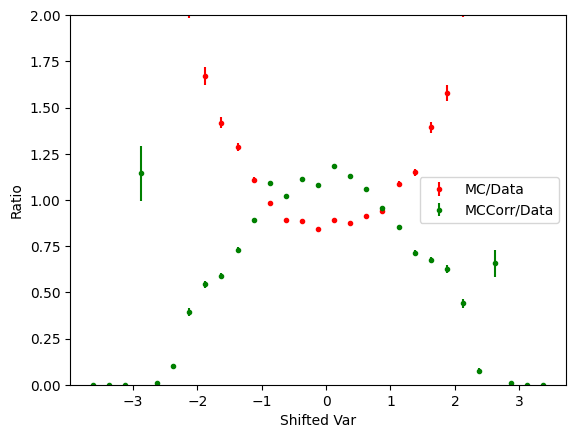

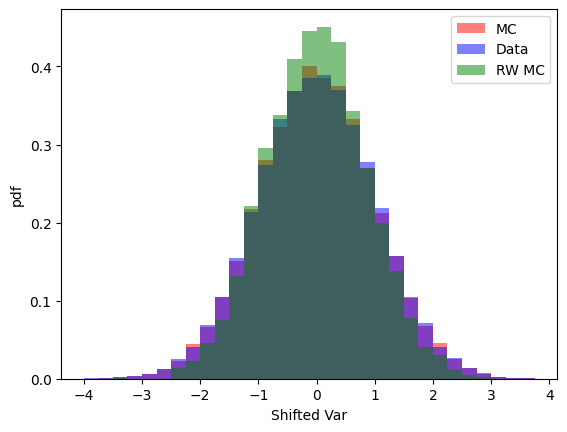

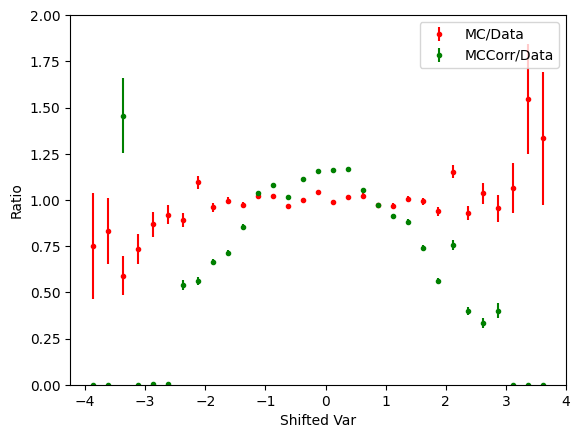

In [16]:
rw_model = simple_MLP_onelayer(data,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()

data_test,test_in,label_in=makeDataSet()
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()

weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])
weightedComp(test_in[:,2][label_in==1],test_in[:,2][label_in==0],weight[label_in==0])
#plt.plot(test_in[:,2][label_in==0],weight[label_in==0],'.')
#plt.show()

/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.0857105100154876, p = 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.61it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step1_1


Loss: 1.192779040336609, p = 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.52it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step2_2


Loss: 0.5060600250959396, p = 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.57it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step3_3


Loss: 1.0969189500808716, p = 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.53it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step4_4


Loss: 1.1151291370391845, p = 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

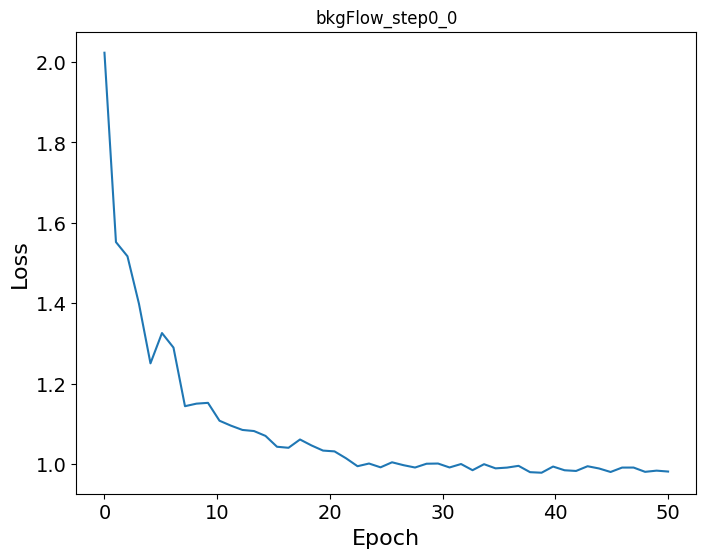

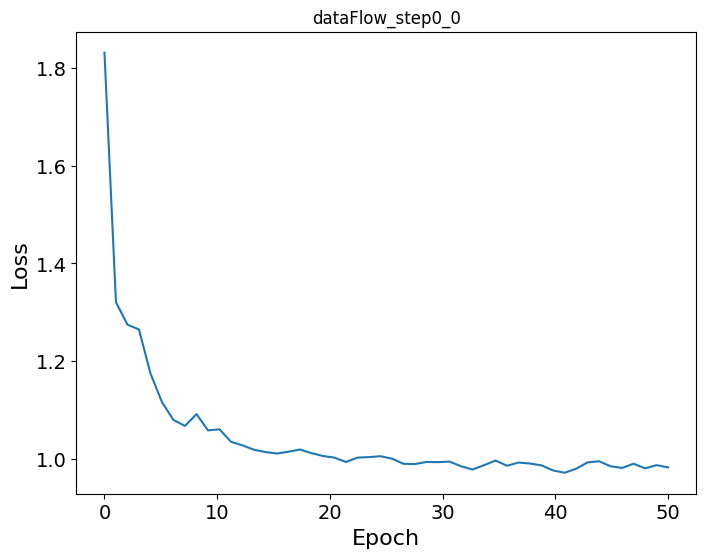

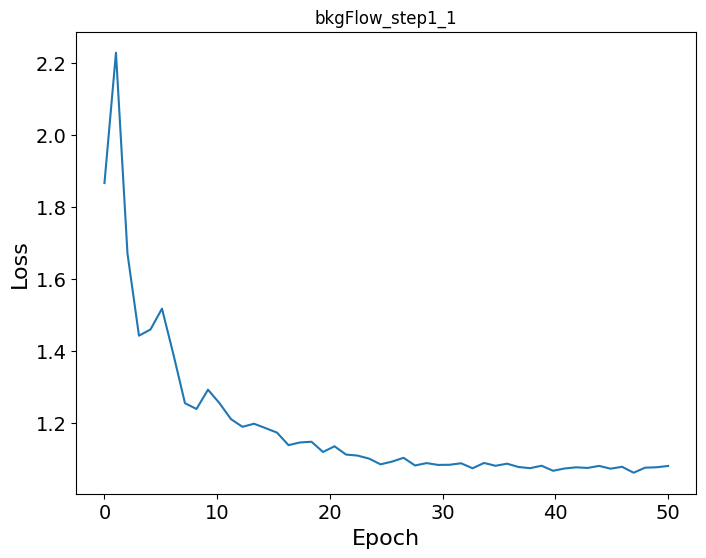

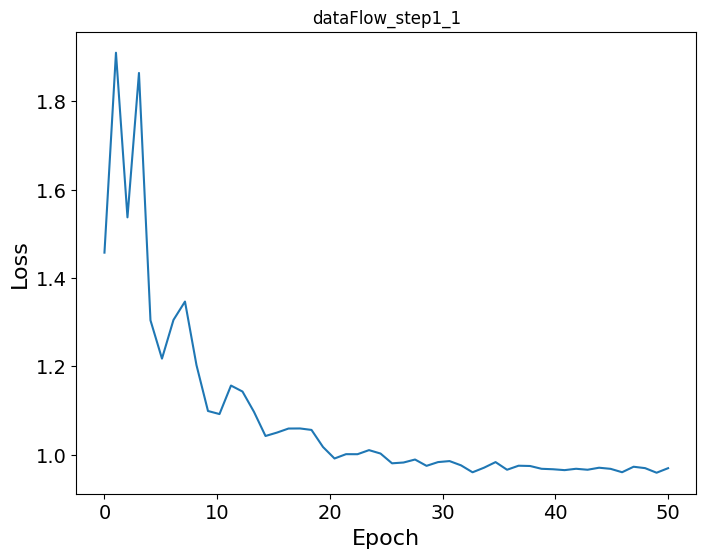

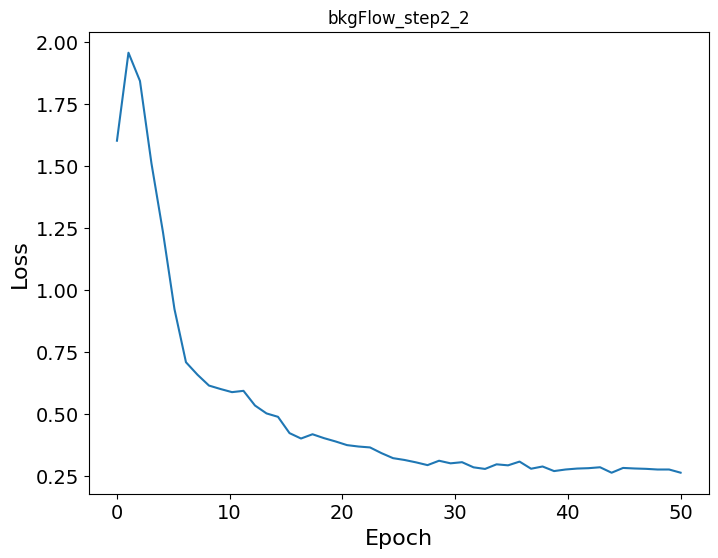

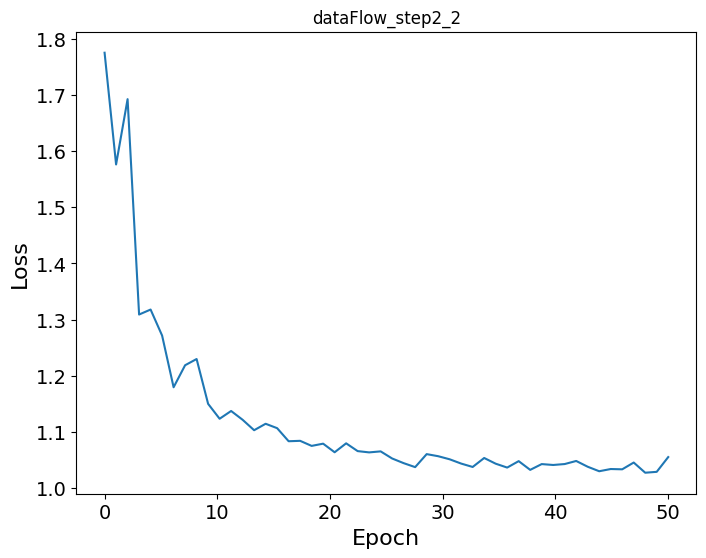

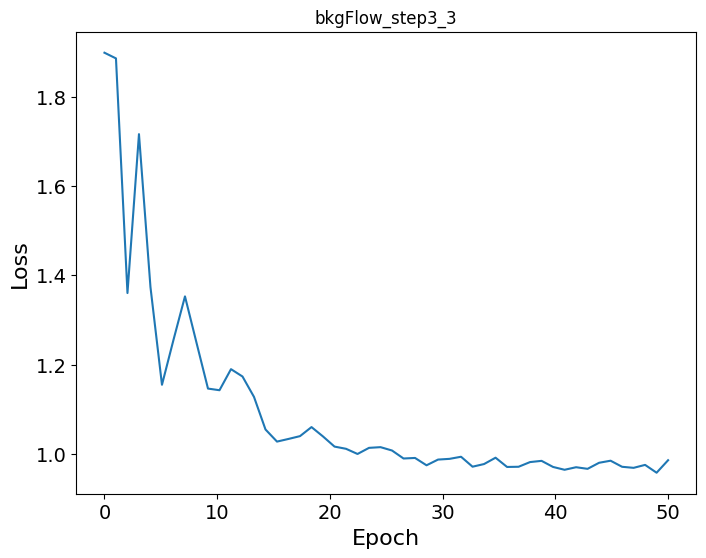

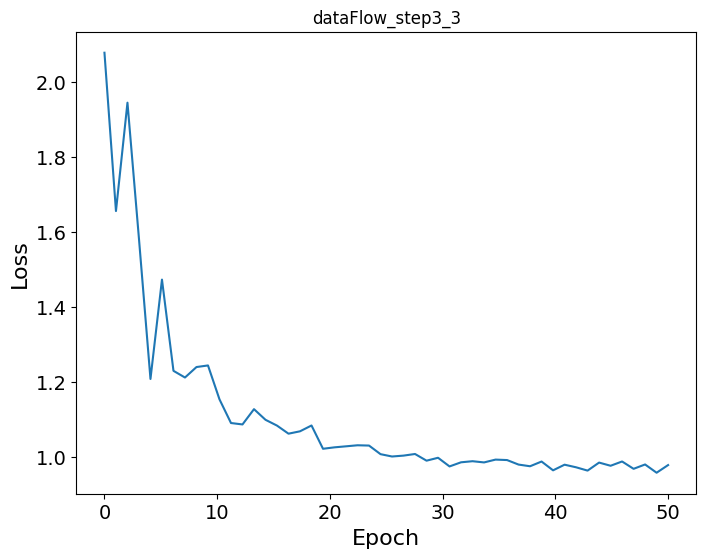

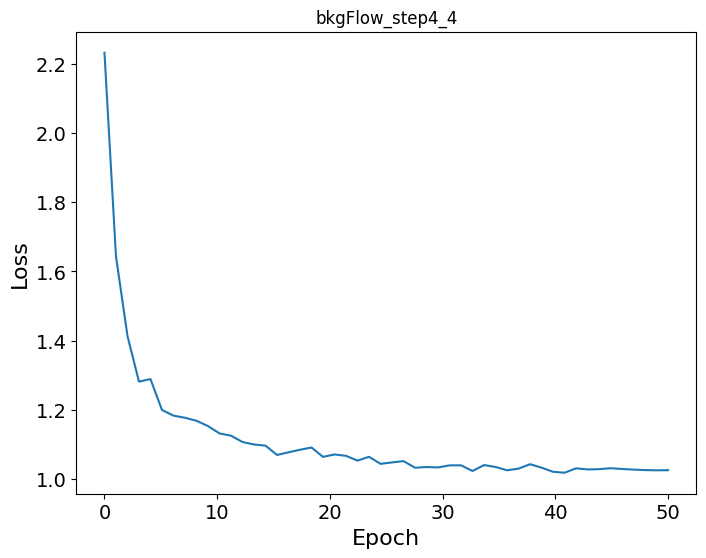

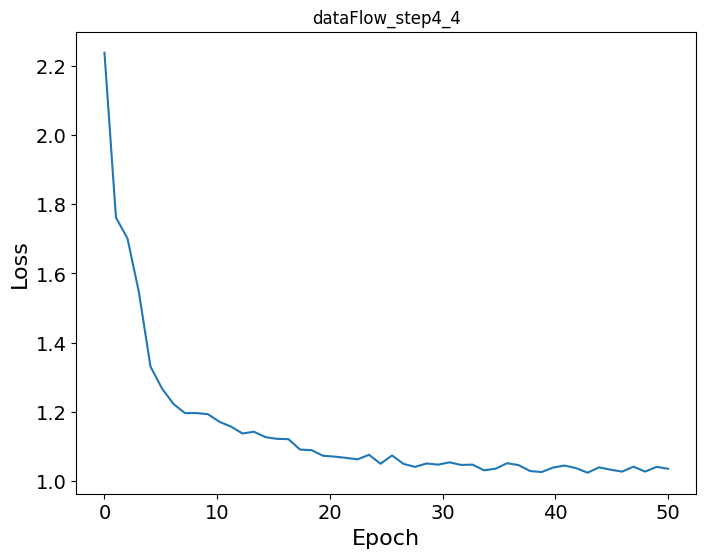

In [60]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test,iNLayers=3,iSeparateScale=False)

  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:607: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_i = torch.tensor(inputs[i],dtype=torch.float32,device=device)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.99it/s]


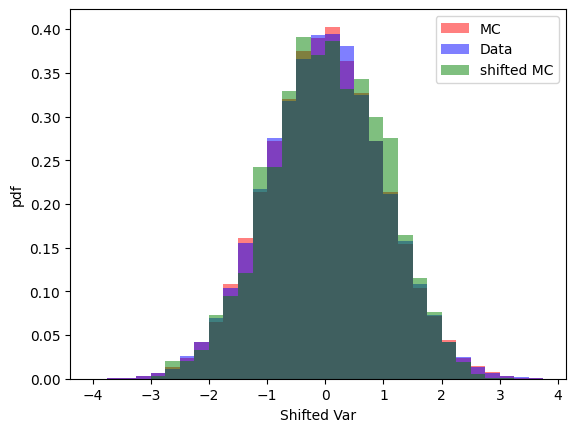

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))


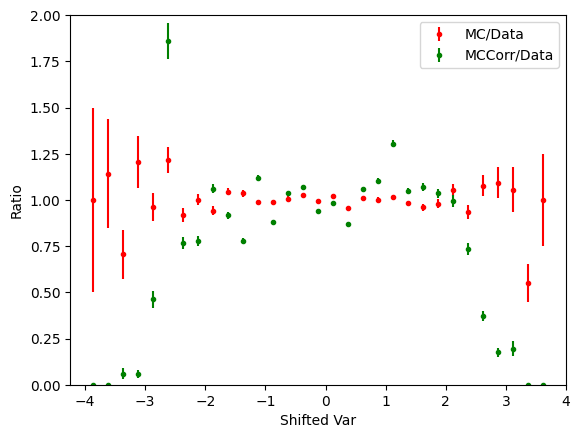

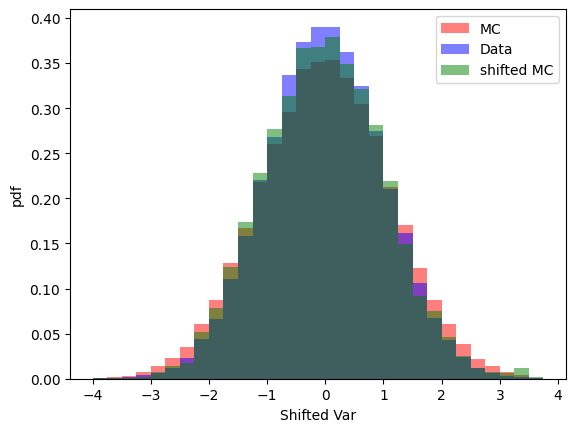

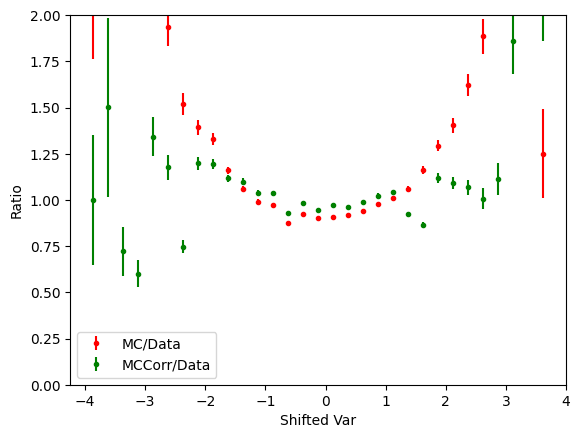

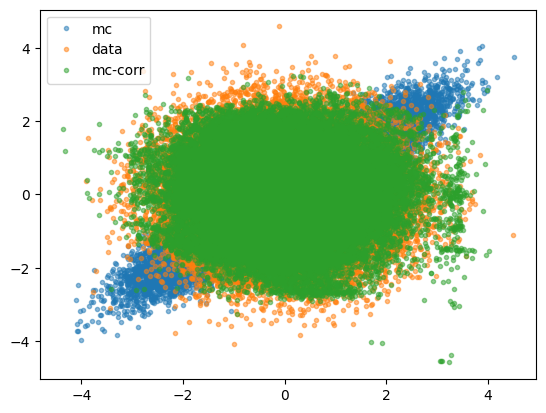

In [61]:
alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])

plt.plot(mc_train[:,1],mc_train[:,2],'.',alpha=0.5,label='mc')
plt.plot(data_train[:,1],data_train[:,2],'.',alpha=0.5,label='data')
plt.plot(mccorr_train['1'],mccorr_train['2'],'.',alpha=0.5,label='mc-corr')
plt.legend()
plt.show()


## Now lets do the same thing as the previous swapping the variables


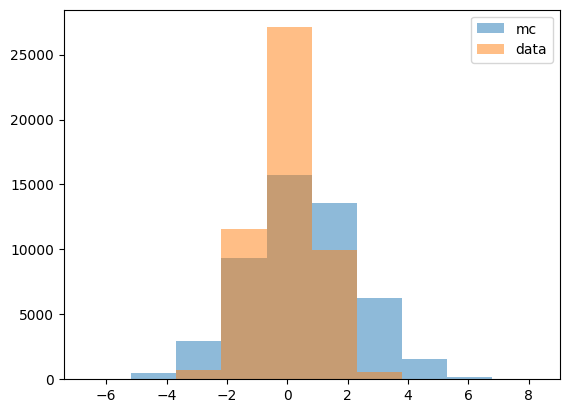

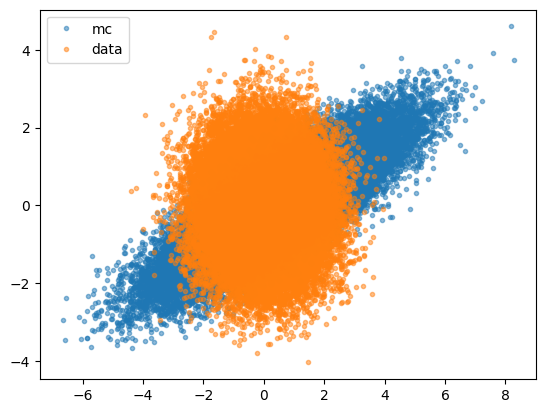

In [40]:
def makeDataSet(iN=50000,iDim=5,iPlot=False):
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v1[:,1] += 1.5*v1[:,2] + 0.5
    if iPlot:
        _,bins,_=plt.hist(v1[:,1],alpha=0.5,label='mc')
        plt.hist(v2[:,1],bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,1],v1[:,2],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,1],v2[:,2],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet(iPlot=True)

Repeat the same as above, reweighting and then quantile

Epoch: 0 LOSS train: 0.5407224297523499 
Epoch: 1 LOSS train: 0.6809471249580383 
Epoch: 2 LOSS train: 0.6009122729301453 
Epoch: 3 LOSS train: 0.574805736541748 
Epoch: 4 LOSS train: 0.5530611276626587 
Epoch: 5 LOSS train: 0.5360443592071533 
Epoch: 6 LOSS train: 0.5237043499946594 
Epoch: 7 LOSS train: 0.5152429342269897 
Epoch: 8 LOSS train: 0.5098754167556763 
Epoch: 9 LOSS train: 0.5068719387054443 
Epoch: 10 LOSS train: 0.5055747628211975 
Epoch: 11 LOSS train: 0.5056136250495911 
Epoch: 12 LOSS train: 0.5064092874526978 
Epoch: 13 LOSS train: 0.5076993703842163 
Epoch: 14 LOSS train: 0.5092889070510864 
Epoch: 15 LOSS train: 0.5110083222389221 
Epoch: 16 LOSS train: 0.5126836895942688 
Epoch: 17 LOSS train: 0.5142607092857361 
Epoch: 18 LOSS train: 0.5157736539840698 
Epoch: 19 LOSS train: 0.5172363519668579 
Epoch: 20 LOSS train: 0.5185033679008484 
Epoch: 21 LOSS train: 0.5197032690048218 
Epoch: 22 LOSS train: 0.5207171440124512 
Epoch: 23 LOSS train: 0.5215756893157959 
Epo

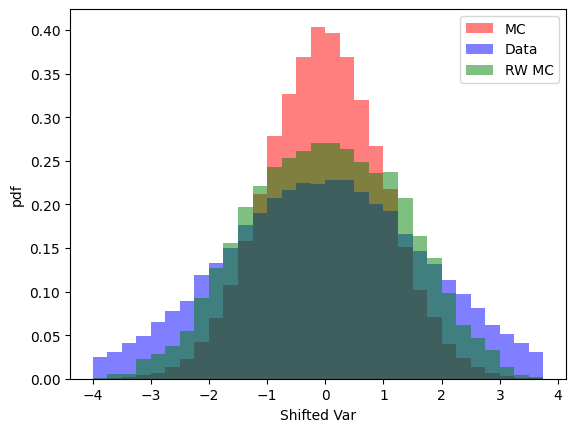

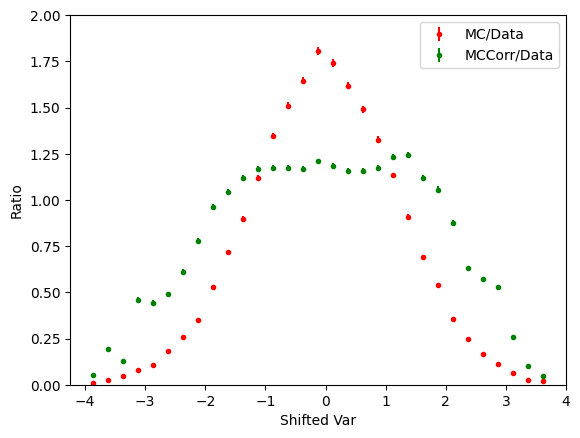

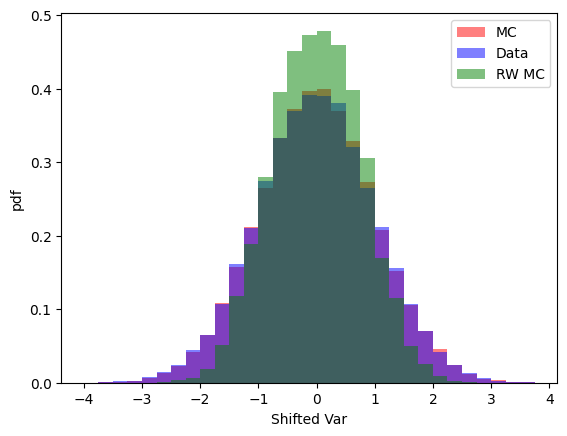

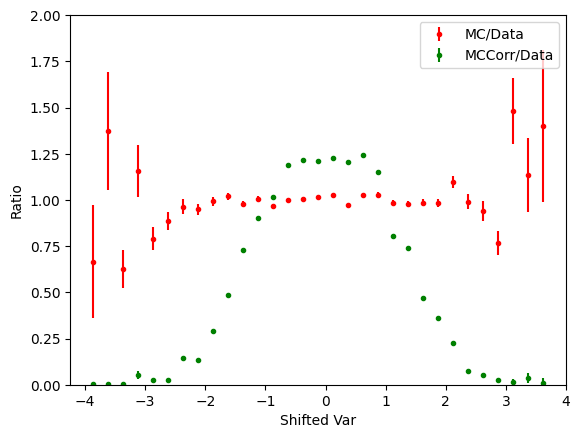

In [34]:
rw_model = simple_MLP_onelayer(data,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()

data_test,test_in,label_in=makeDataSet()
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()

weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])
weightedComp(test_in[:,2][label_in==1],test_in[:,2][label_in==0],weight[label_in==0])


/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.1626847410202026, p = 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.26s/it]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step1_1


Loss: 1.1658449935913087, p = 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.36s/it]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step2_2


Loss: 0.24207801576936616, p = 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.34s/it]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step3_3


Loss: 1.1790330076217652, p = 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.39s/it]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step4_4


Loss: 1.0993338131904602, p = 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

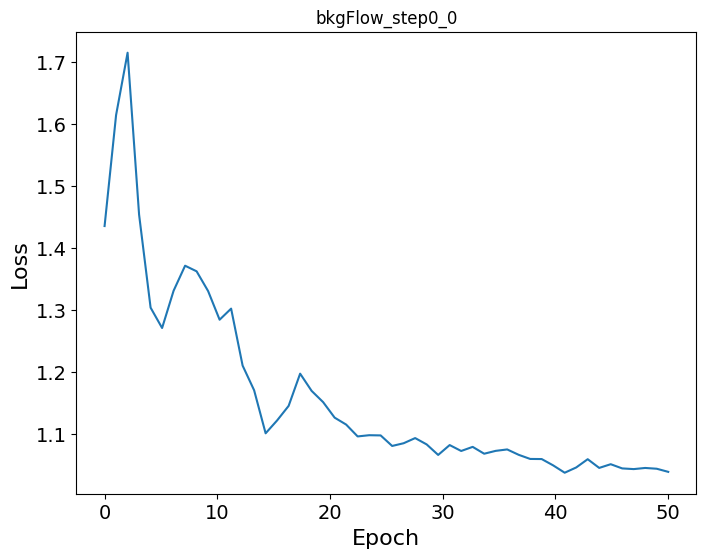

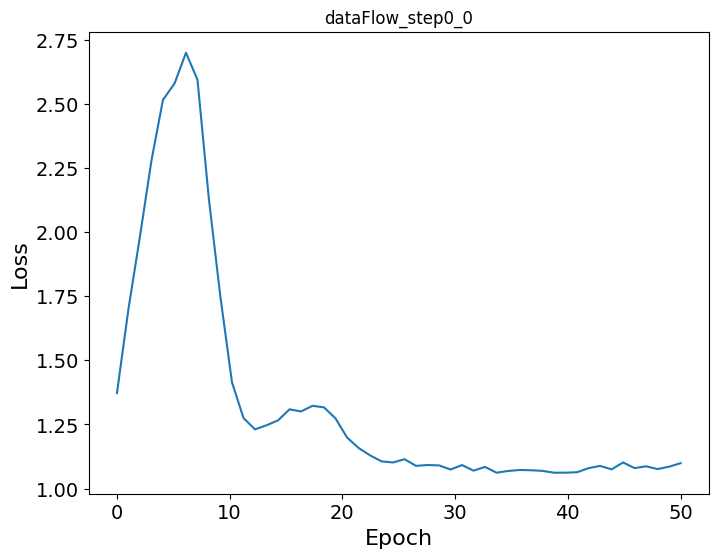

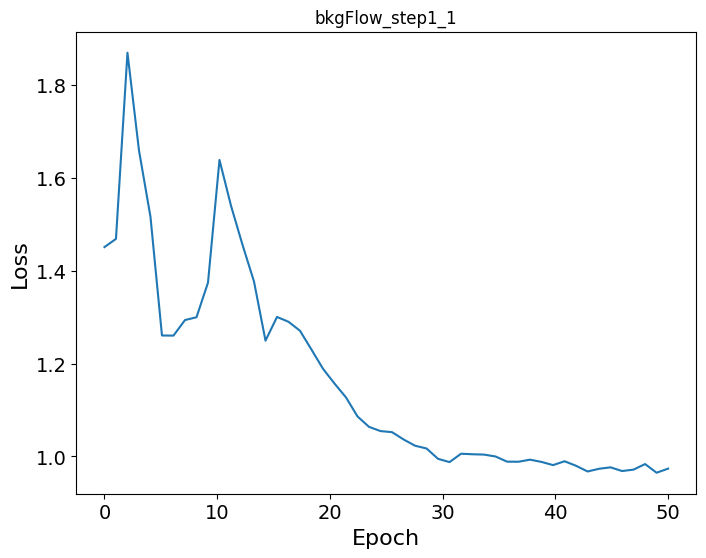

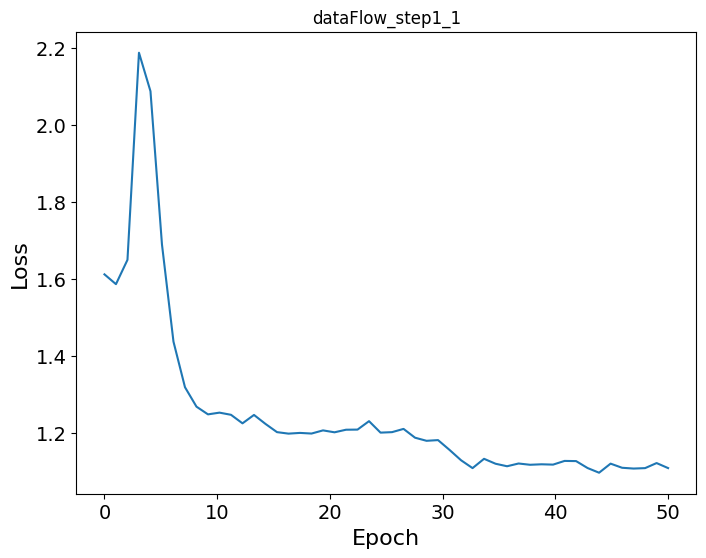

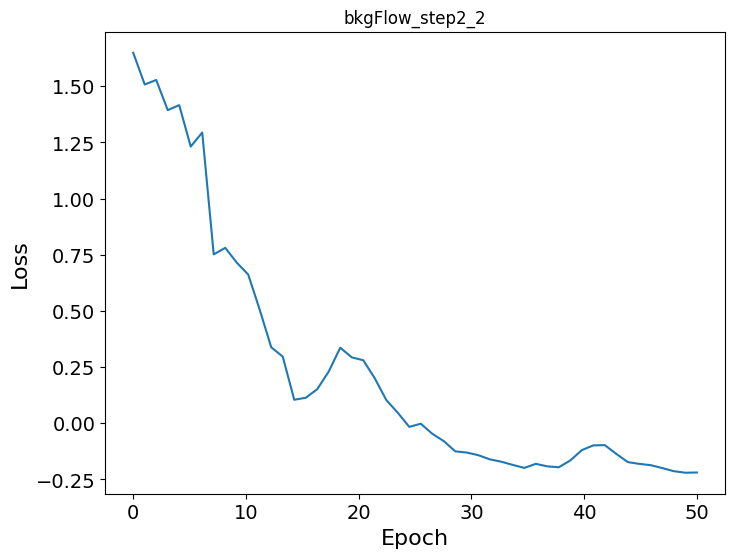

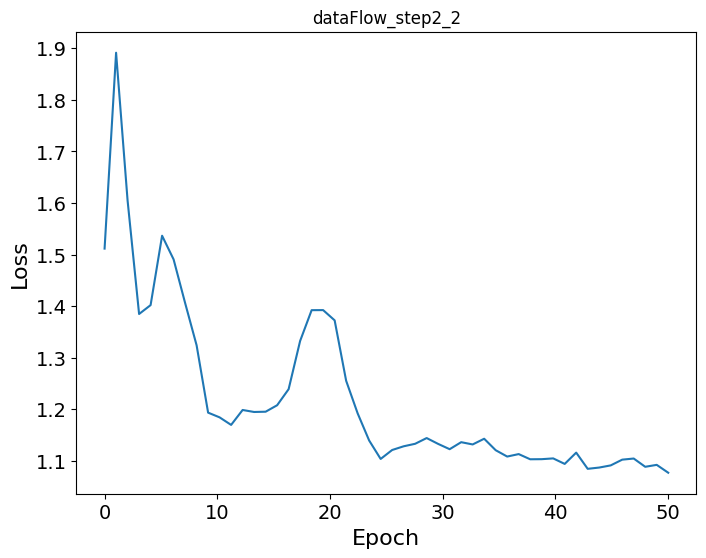

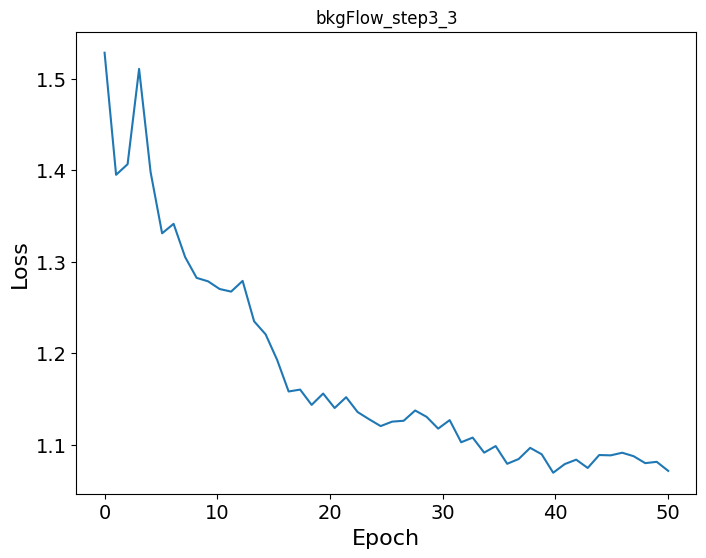

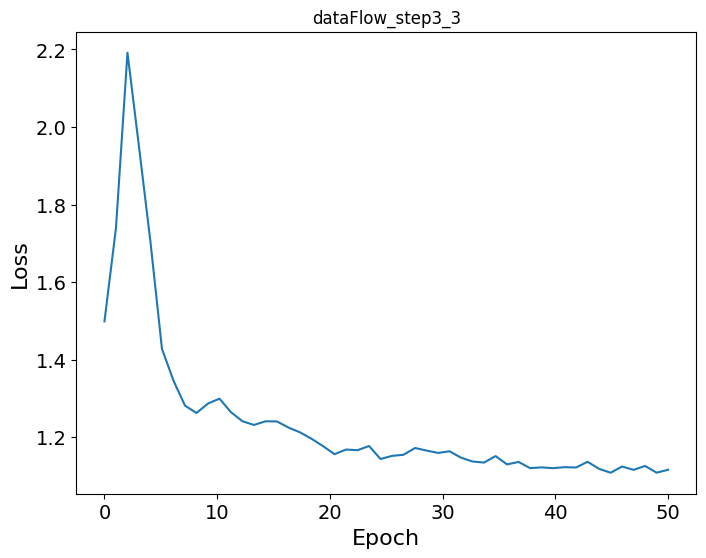

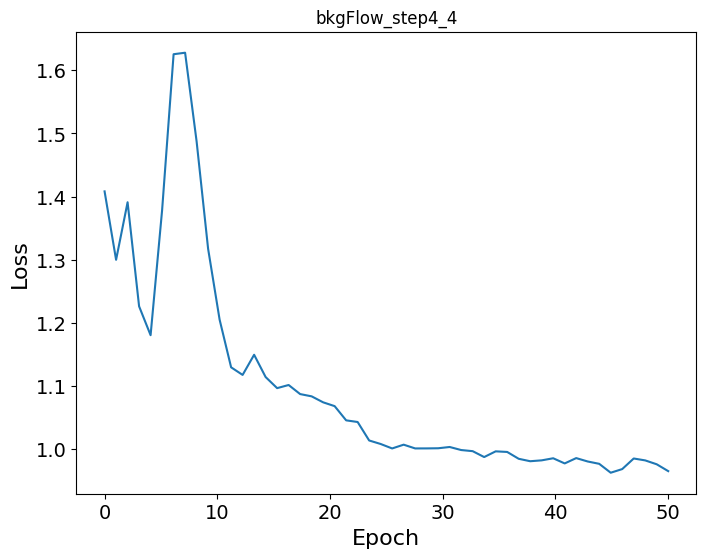

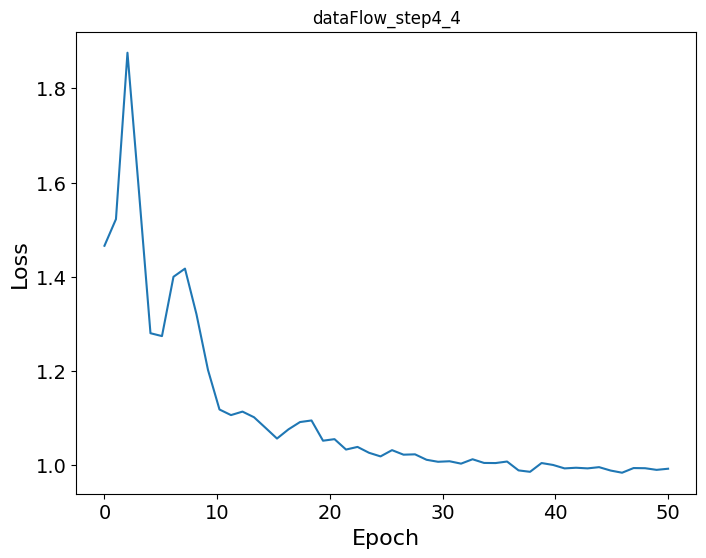

In [26]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test,iNLayers=3)

  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:607: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_i = torch.tensor(inputs[i],dtype=torch.float32,device=device)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.45it/s]


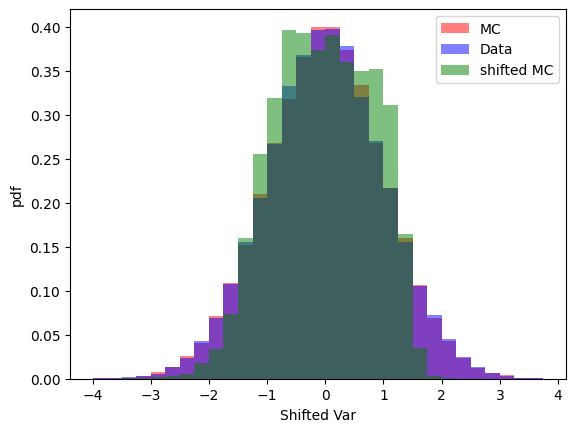

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))


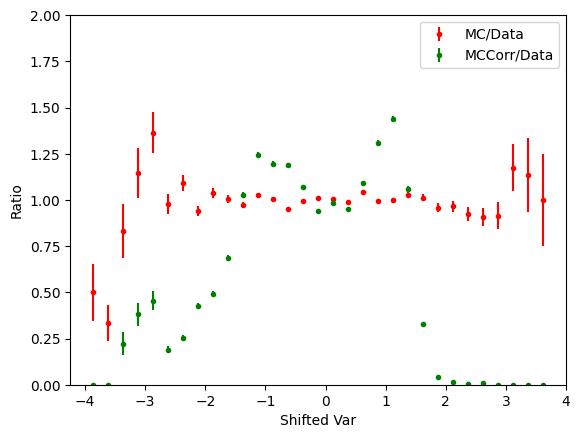

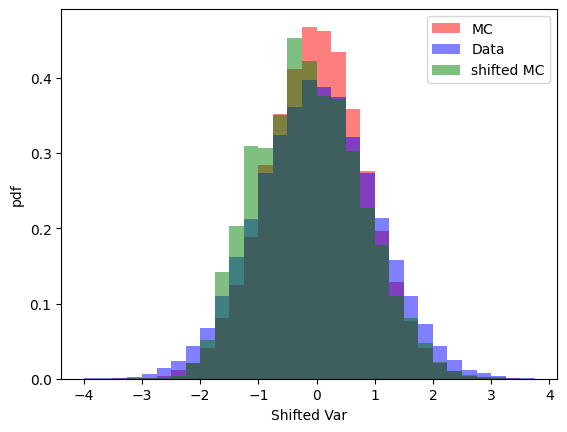

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))


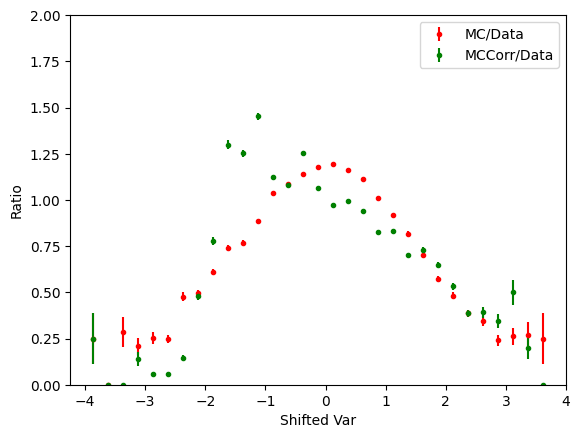

In [27]:
alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])

## Variables that are additve

This is potentailly a case where reweight would work better, because it enforces kinematic conservation. The idea here is one of the variables, will be the exact sum of two variables in a similar way the jet mass is the sum of the 4-vectors. For this, we will shift two of teh variables by a small amount and then have the third variable be the sum ie 

$$
data_{1} = 1.05 mc_{1} \\
data_{2} = 1.15 mc_{2} \\
data_{3} = data_{1} + data_{2} \\
mc_{3} = mc_{1} + mc_{2} \\
v_{i} \in \mathcal{N}(0,1) \forall i \neq 3
$$

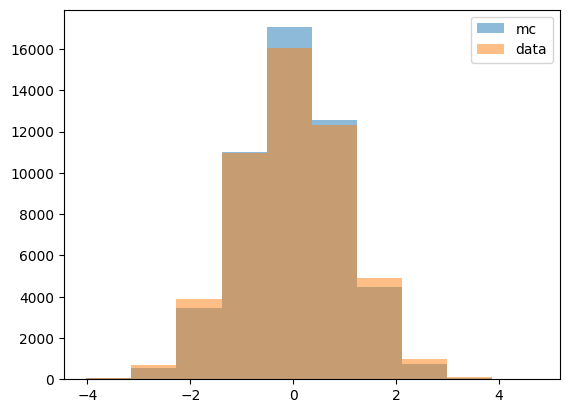

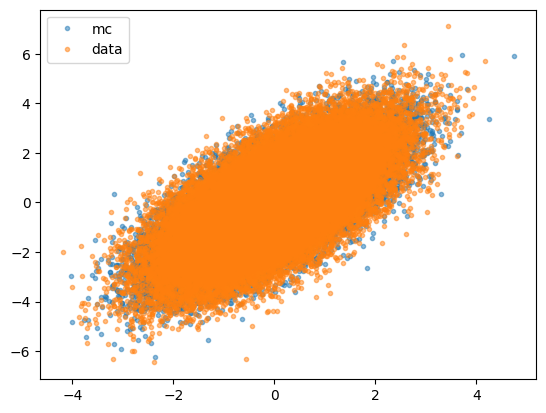

In [62]:
def makeDataSet(iN=50000,iDim=5,iPlot=False):
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v2[:,1] *= 1.05
    v2[:,2] *= 1.15
    v1[:,3]  = v1[:,1] + v1[:,2]
    v2[:,3]  = v2[:,1] + v2[:,2]
    if iPlot:
        _,bins,_=plt.hist(v1[:,1],alpha=0.5,label='mc')
        plt.hist(v2[:,1],bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,1],v1[:,3],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,1],v2[:,3],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet(iPlot=True)

Epoch: 0 LOSS train: 0.5809189081192017 
Epoch: 1 LOSS train: 0.7023988366127014 
Epoch: 2 LOSS train: 0.6840798258781433 
Epoch: 3 LOSS train: 0.6967673301696777 
Epoch: 4 LOSS train: 0.7042576670646667 
Epoch: 5 LOSS train: 0.7071884274482727 
Epoch: 6 LOSS train: 0.7037926316261292 
Epoch: 7 LOSS train: 0.7030494213104248 
Epoch: 8 LOSS train: 0.7055222988128662 
Epoch: 9 LOSS train: 0.7047320008277893 
Epoch: 10 LOSS train: 0.7036484479904175 
Epoch: 11 LOSS train: 0.702595055103302 
Epoch: 12 LOSS train: 0.7017570734024048 
Epoch: 13 LOSS train: 0.7010523080825806 
Epoch: 14 LOSS train: 0.7004925608634949 
Epoch: 15 LOSS train: 0.6998768448829651 
Epoch: 16 LOSS train: 0.6993758678436279 
Epoch: 17 LOSS train: 0.6989189982414246 
Epoch: 18 LOSS train: 0.6984544992446899 
Epoch: 19 LOSS train: 0.6980687975883484 
Epoch: 20 LOSS train: 0.6977146863937378 
Epoch: 21 LOSS train: 0.6973909139633179 
Epoch: 22 LOSS train: 0.6960973143577576 
Epoch: 23 LOSS train: 0.699637234210968 
Epoc

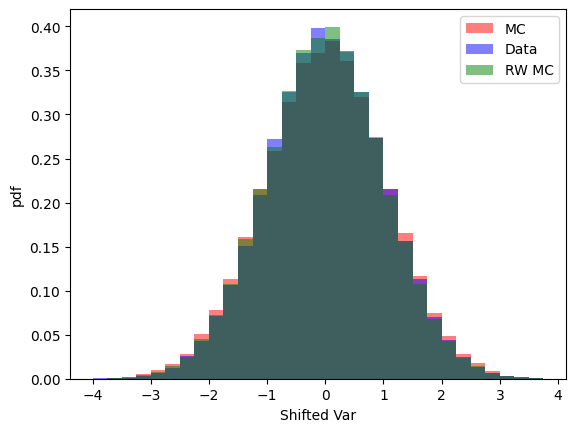

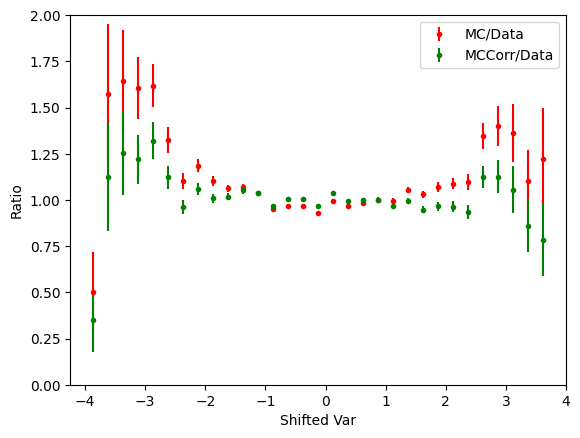

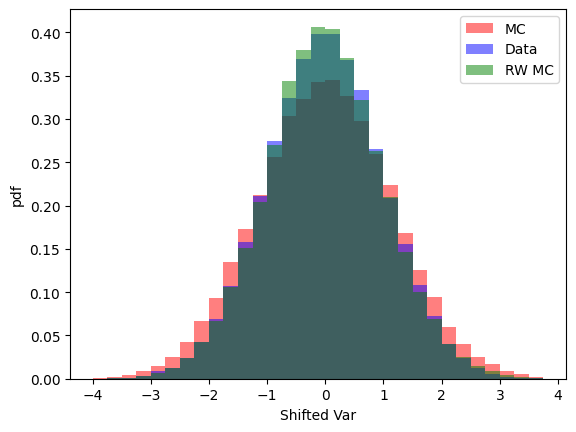

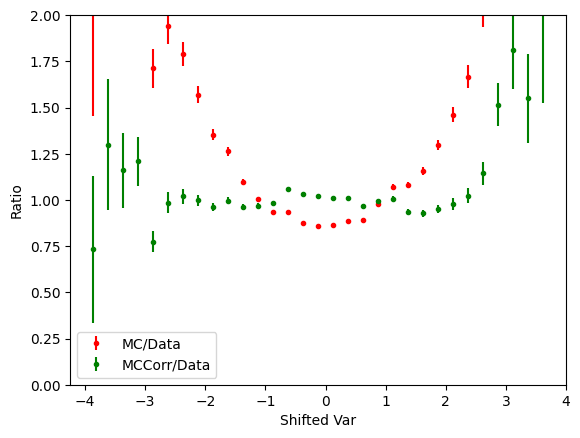

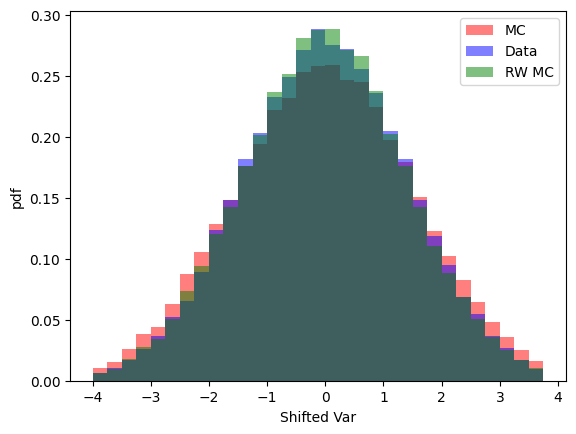

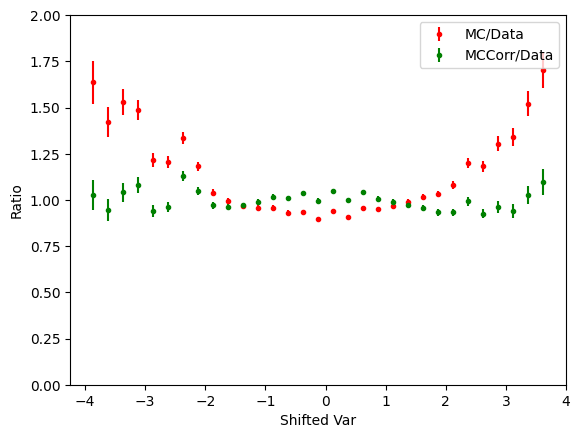

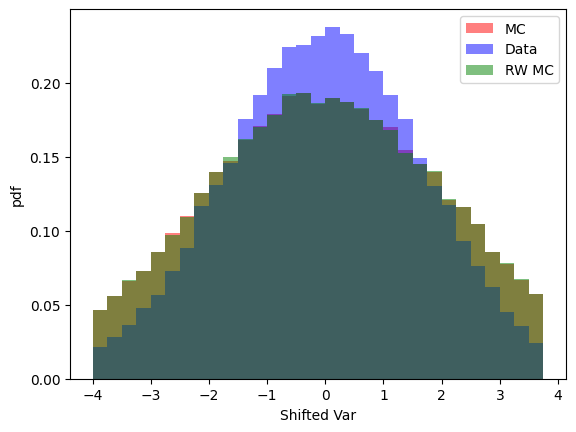

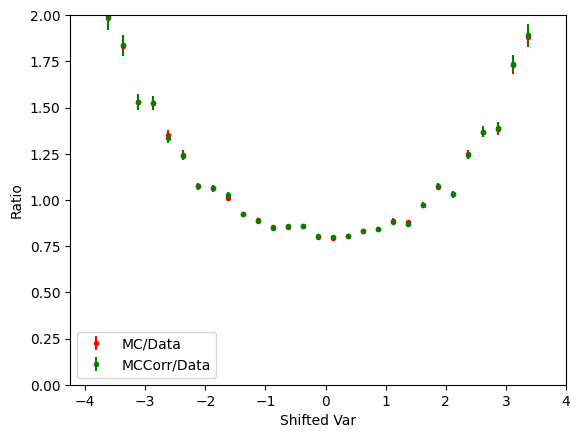

In [63]:
rw_model = simple_MLP_onelayer(data,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()

data_test,test_in,label_in=makeDataSet()
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()

weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])
weightedComp(test_in[:,2][label_in==1],test_in[:,2][label_in==0],weight[label_in==0])
weightedComp(test_in[:,3][label_in==1],test_in[:,3][label_in==0],weight[label_in==0])

data_conserved=data_train[:,3]-data_train[:,2]-data_train[:,1]
mc_conserved=mc_train[:,3]-mc_train[:,2]-mc_train[:,1]
weightedComp(data_conserved,mc_conserved,weight[label_in==0])



/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.0558079981803894, p = 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.99it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step1_1


Loss: 1.0440279042720795, p = 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.12it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step2_2


Loss: 0.9814395892620087, p = 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.67it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step3_3


Loss: -0.36590063413605095, p = 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.35it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step4_4


Loss: 0.9649996316432953, p = 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.55it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

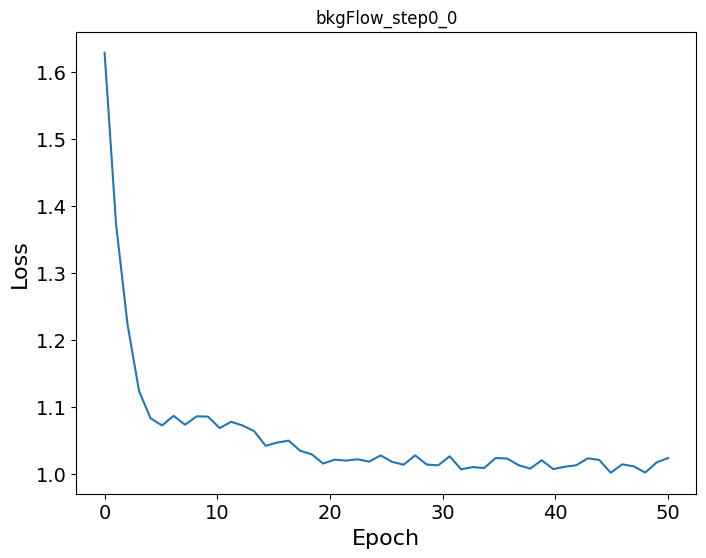

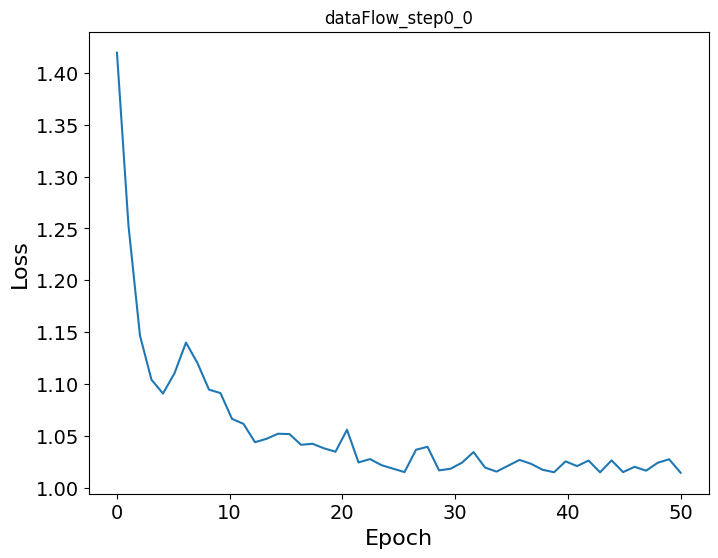

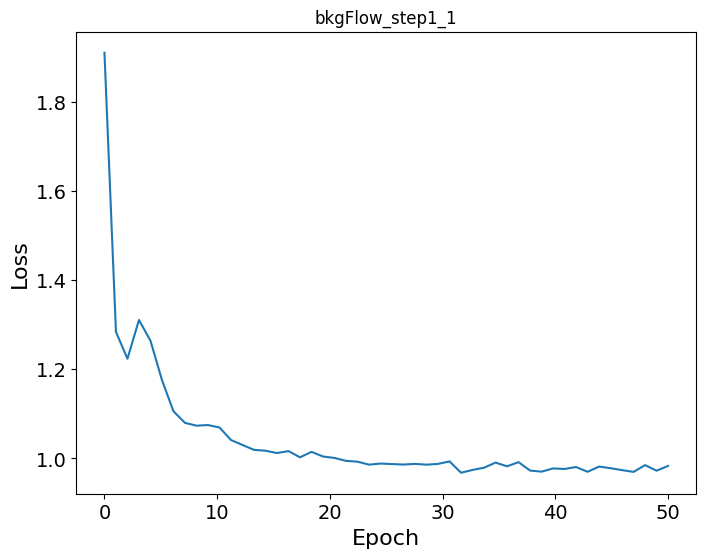

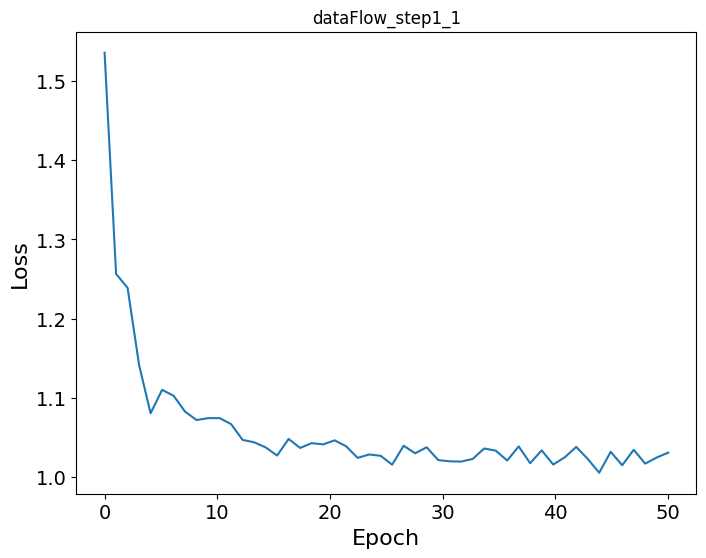

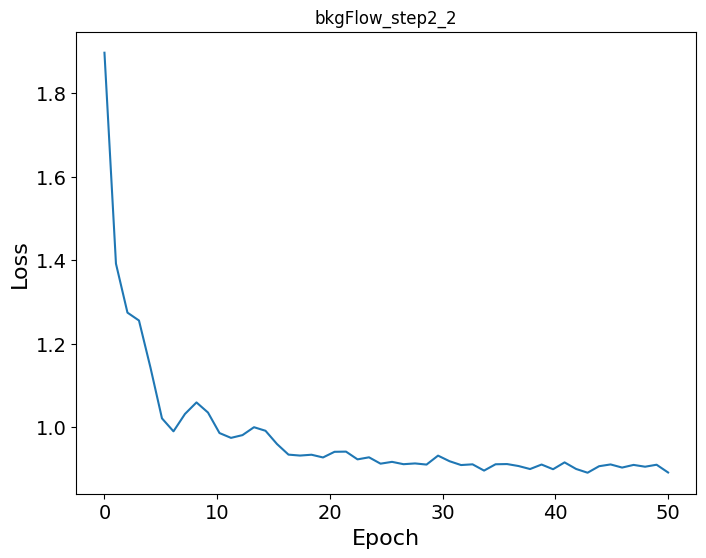

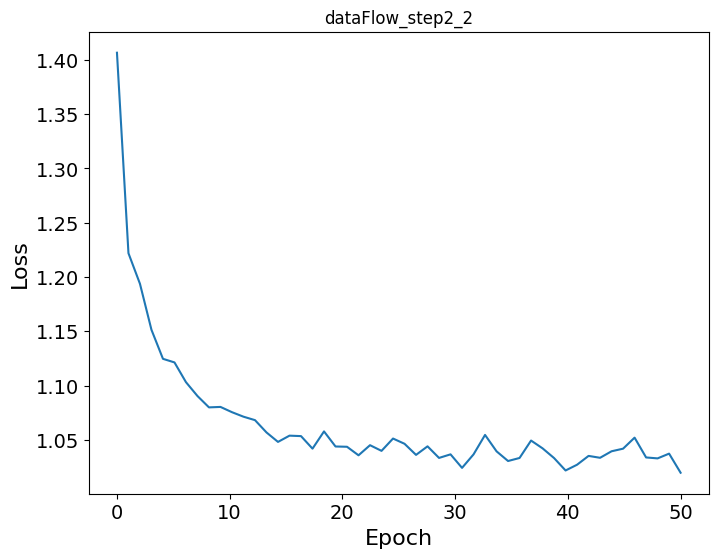

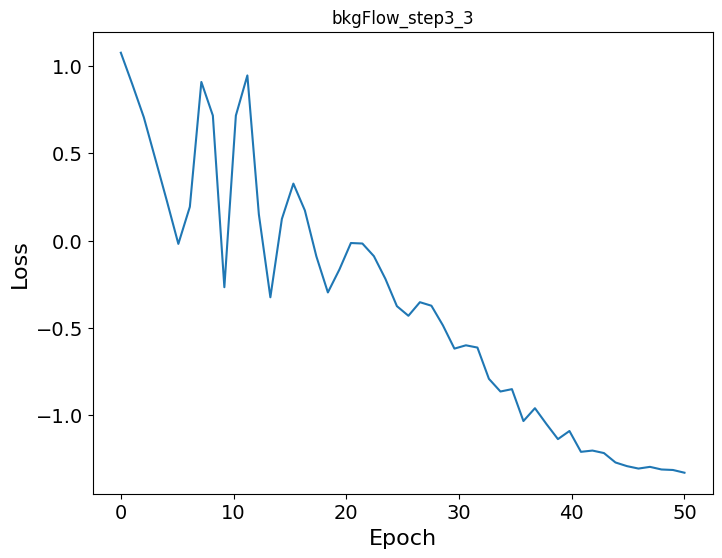

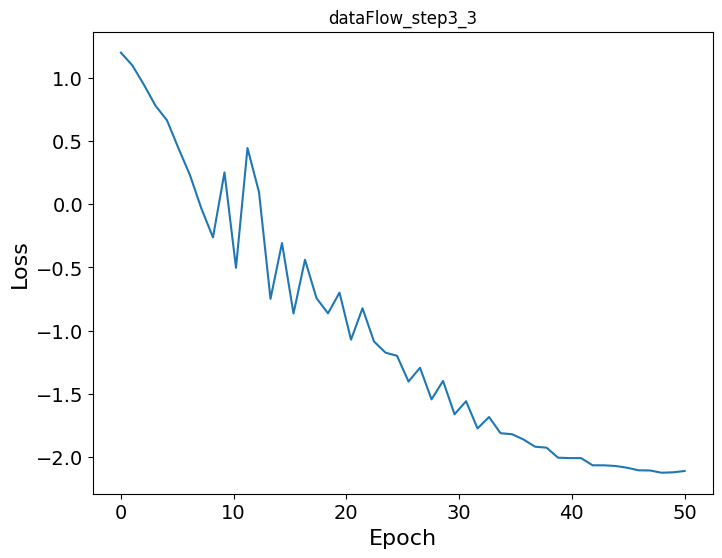

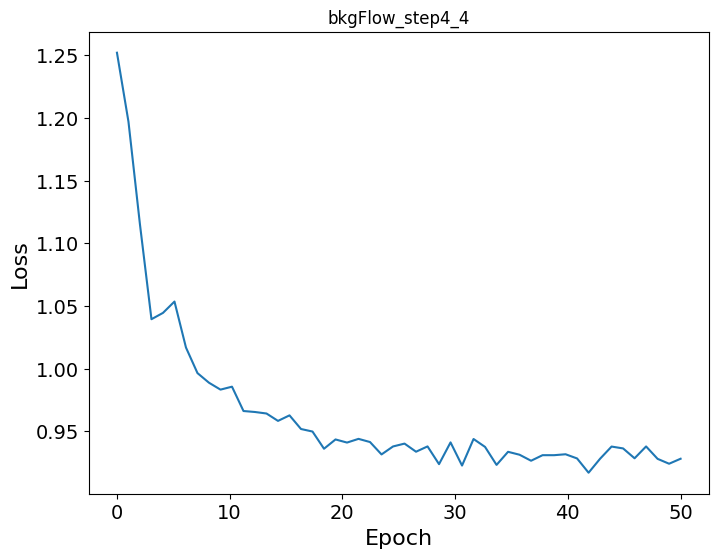

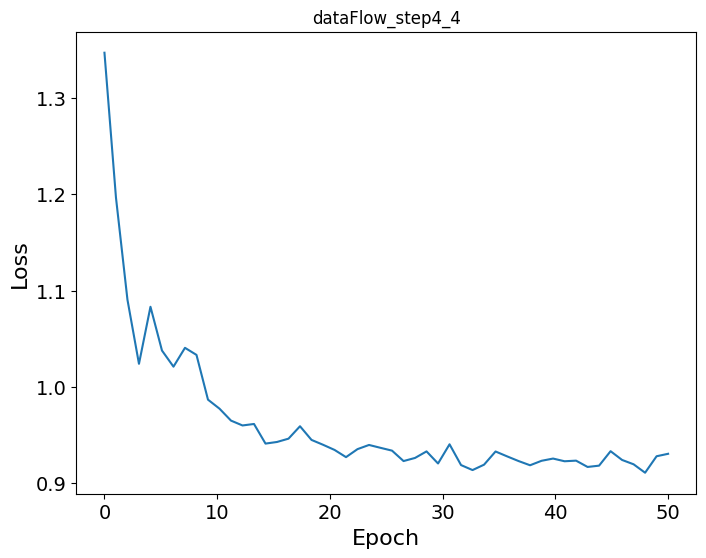

In [64]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test,iNLayers=3,iSeparateScale=True)

  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:607: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_i = torch.tensor(inputs[i],dtype=torch.float32,device=device)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.64it/s]


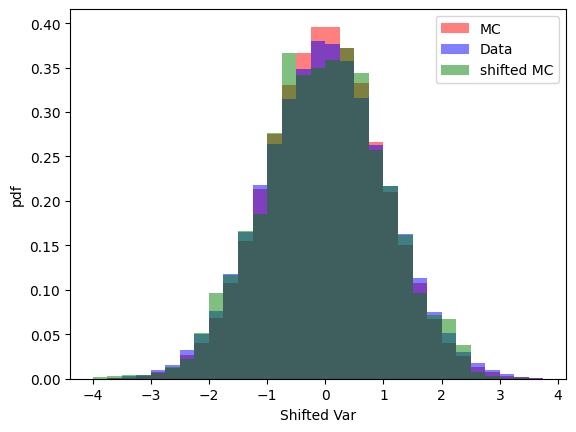

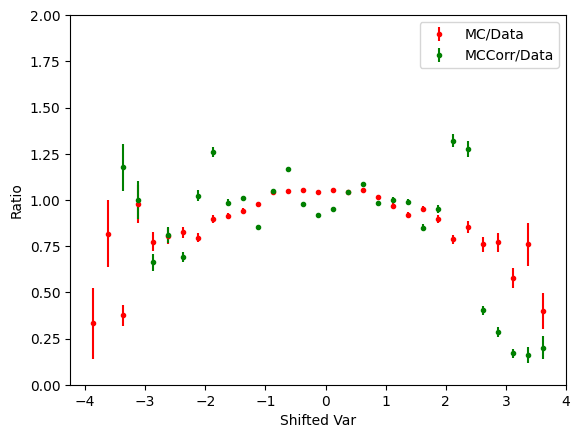

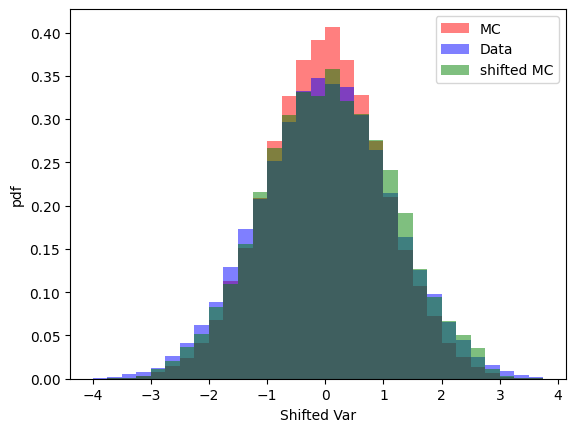

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))


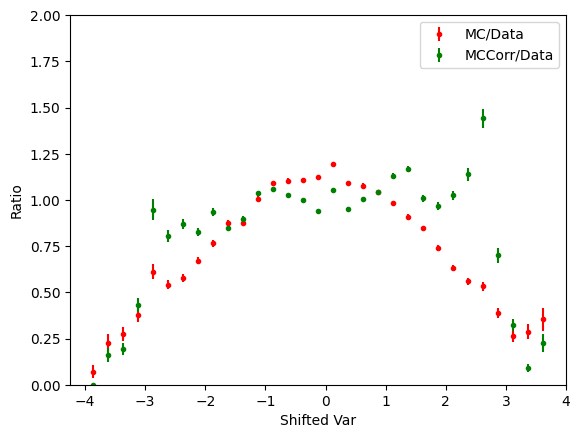

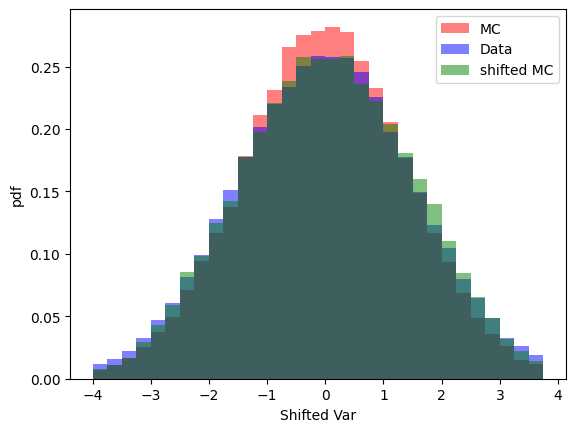

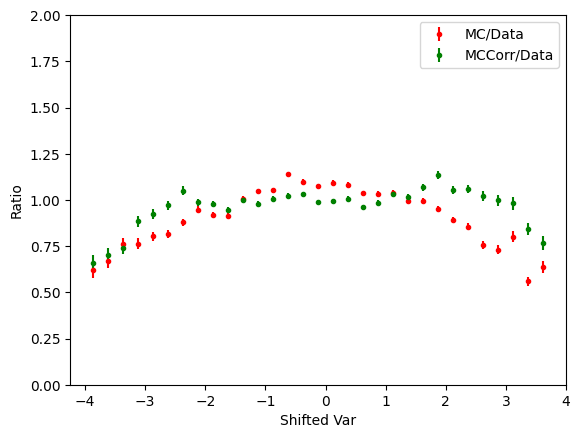

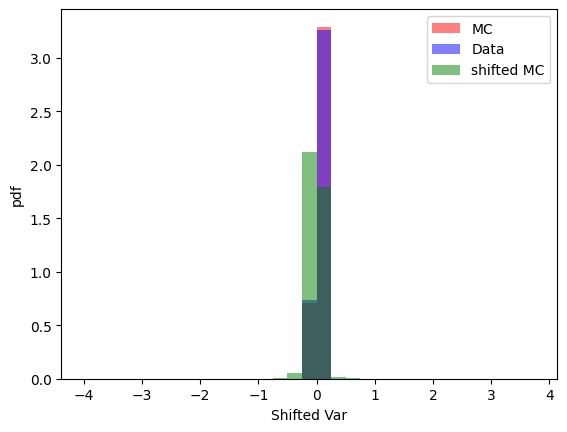

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))
/Users/philipharris/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3607: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


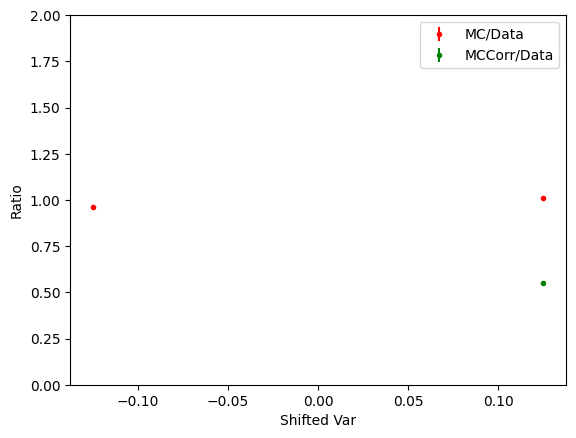

In [65]:
alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,3],mc_train[:,3],mccorr_train['3'])
data_conserved=data_train[:,3]-data_train[:,2]-data_train[:,1]
mc_conserved=mc_train[:,3]-mc_train[:,2]-mc_train[:,1]
mccorr_conserved=mccorr_train['3']-mccorr_train['2']-mccorr_train['1']
quantileComp(data_conserved,mc_conserved,mccorr_conserved)



In [66]:
##swapping order just ot test
def makeDataSet(iN=50000,iDim=5,iPlot=False):
    v1=torch.randn(iN,iDim)
    v2=torch.randn(iN,iDim)
    v2[:,2] *= 1.05
    v2[:,3] *= 1.15
    v1[:,1]  = v1[:,2] + v1[:,3]
    v2[:,1]  = v2[:,2] + v2[:,3]
    if iPlot:
        _,bins,_=plt.hist(v1[:,1],alpha=0.5,label='mc')
        plt.hist(v2[:,1],bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,1],v1[:,3],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,1],v2[:,3],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
    tot=torch.cat([v1,v2])
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
#outdata,_,_=makeDataSet()
#print(outdata[0])

/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.1715067219734192, p = 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.34it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step1_1


Loss: 1.1954835700988768, p = 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step2_2


Loss: 0.7984922790527343, p = 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.30it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step3_3


Loss: -0.6825984736159444, p = 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.16it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step4_4


Loss: 1.2079959726333618, p = 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

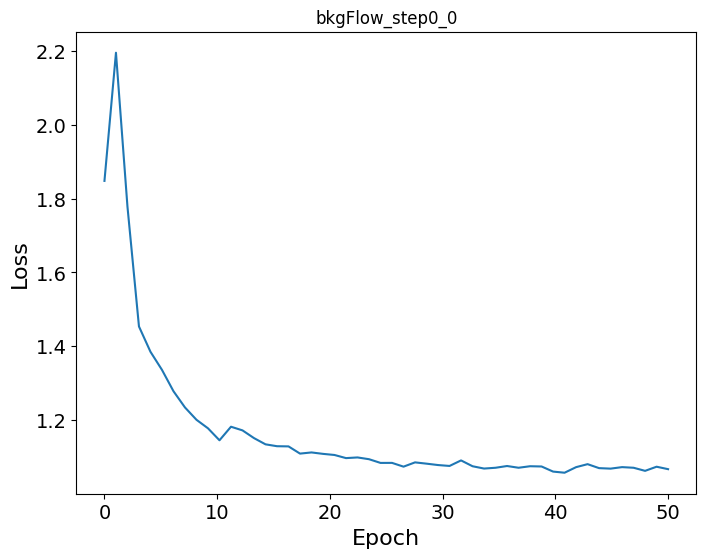

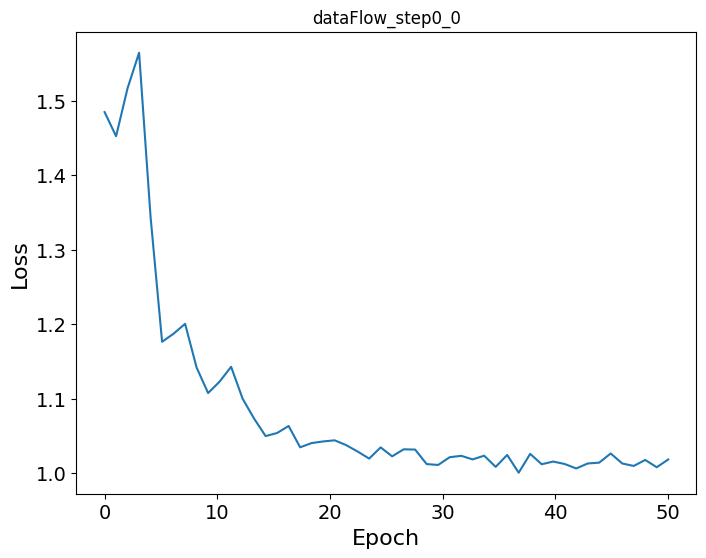

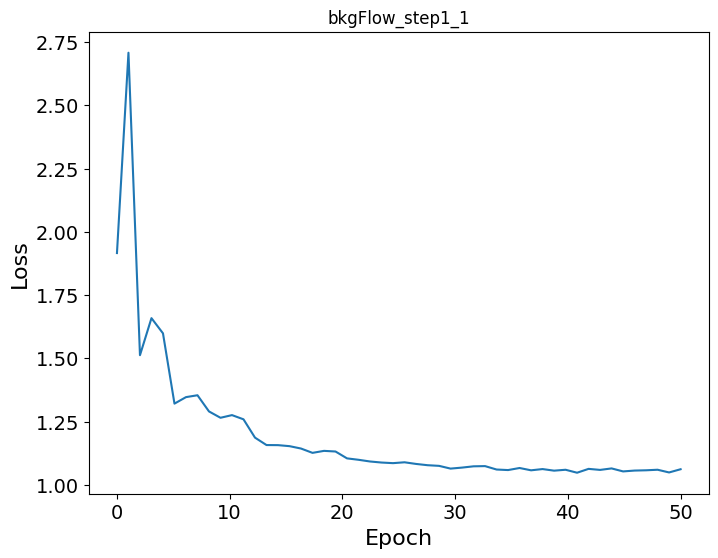

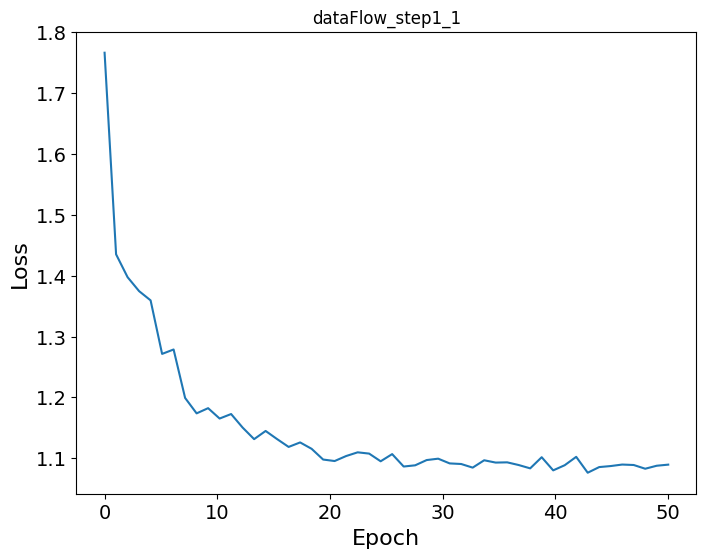

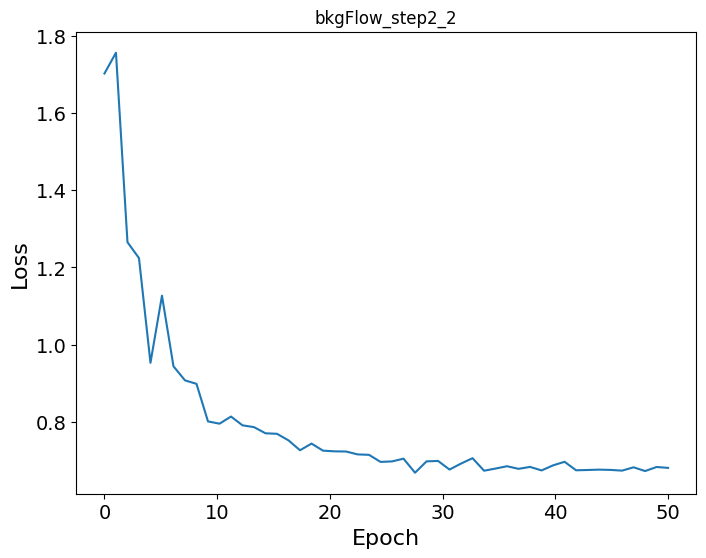

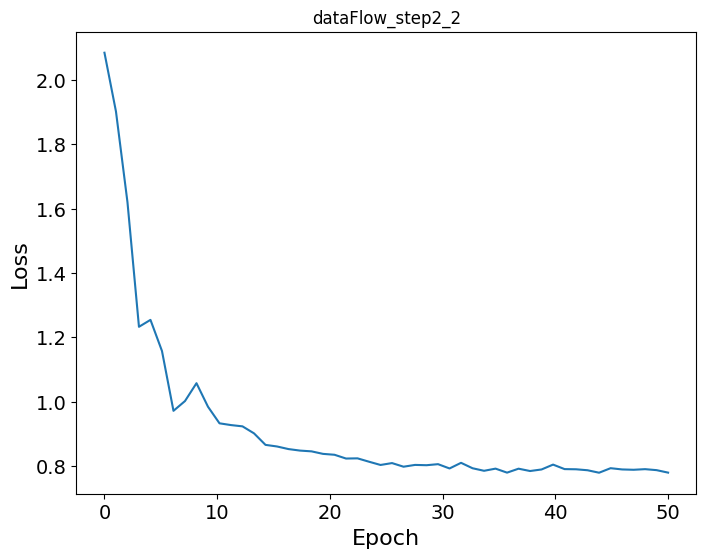

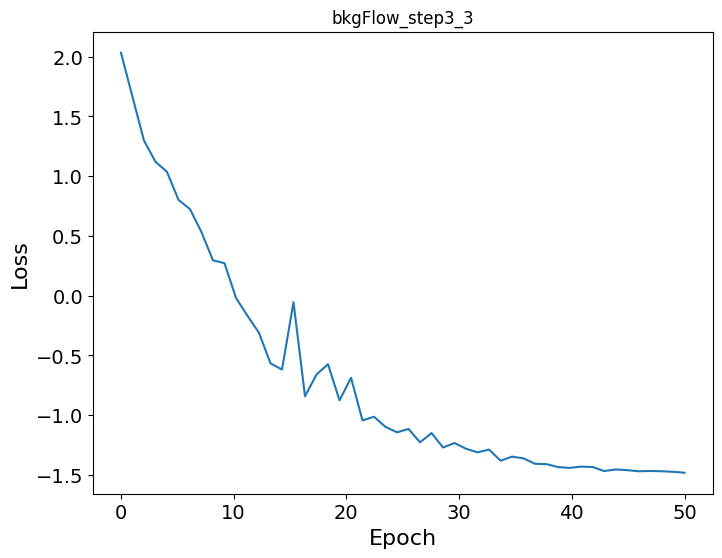

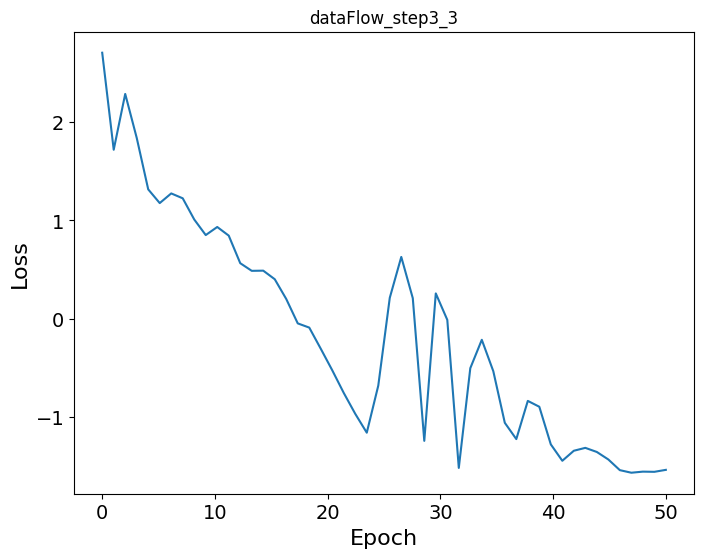

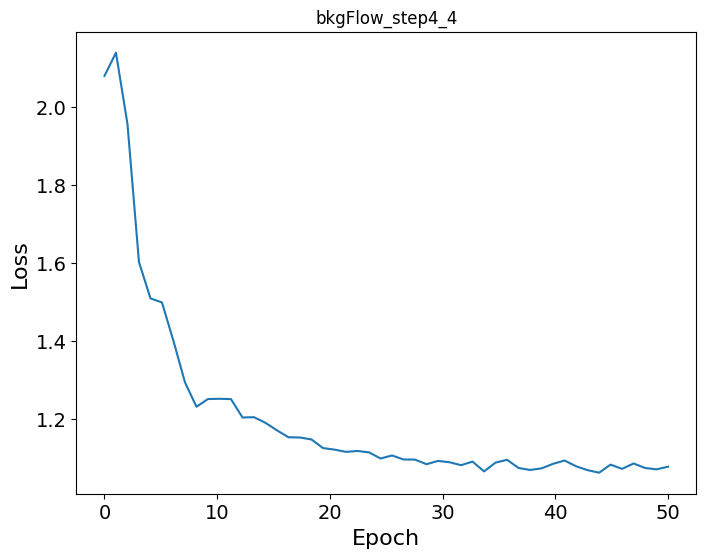

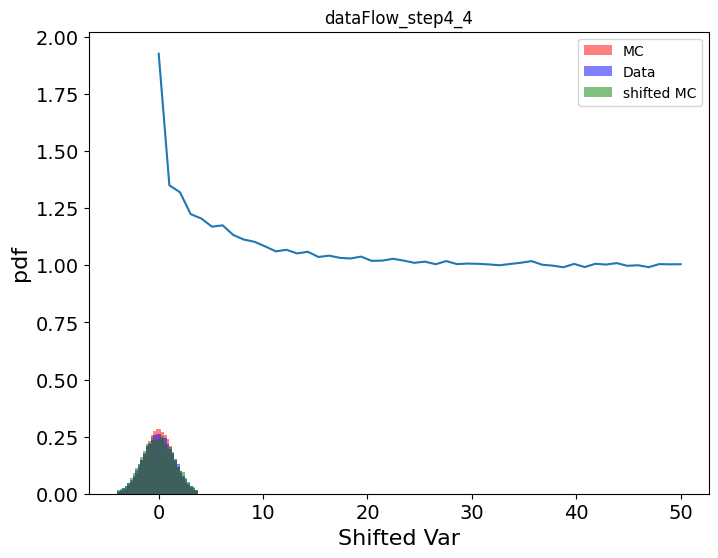

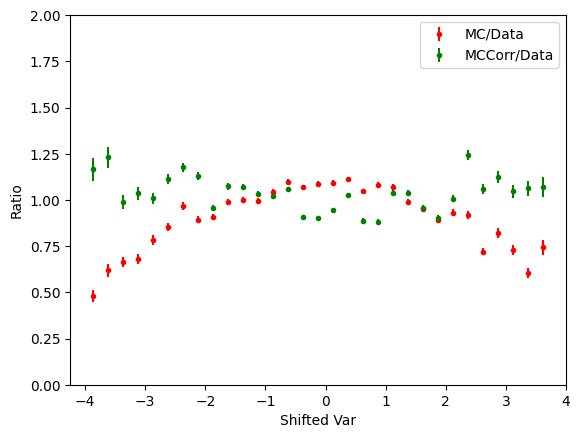

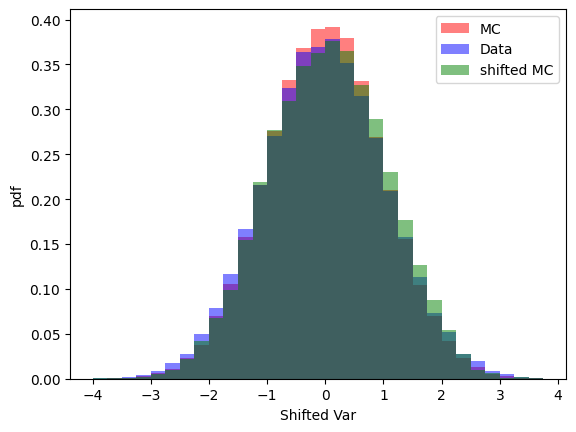

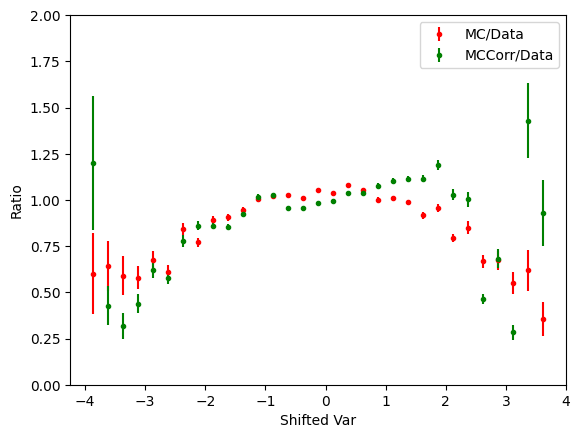

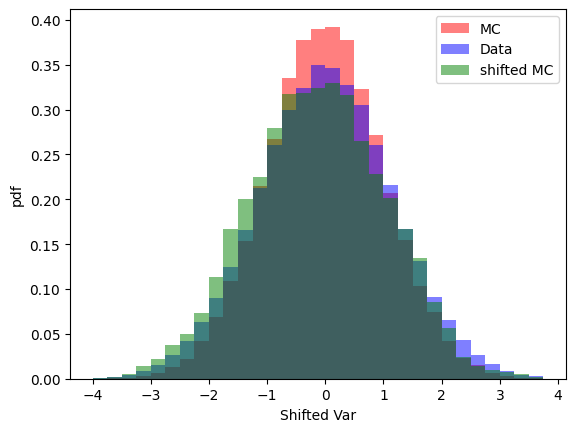

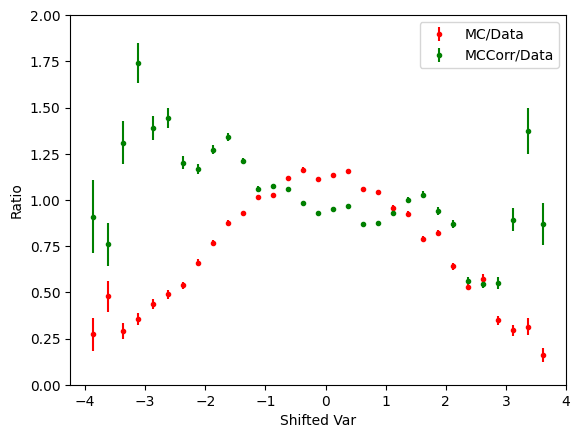

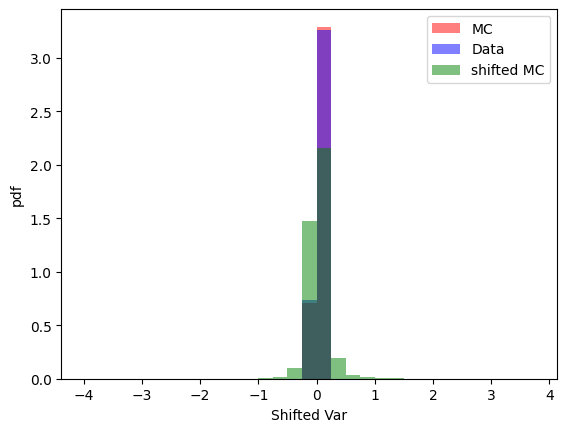

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))
/Users/philipharris/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3607: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


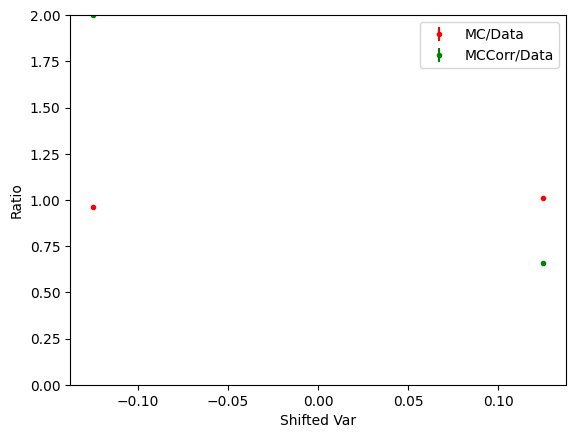

In [67]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test,iNLayers=3,iSeparateScale=True)
alldata_test2,test2_in,labeltest2_in=makeDataSet()
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,3],mc_train[:,3],mccorr_train['3'])
data_conserved=data_train[:,1]-data_train[:,3]-data_train[:,2]
mc_conserved=mc_train[:,1]-mc_train[:,3]-mc_train[:,2]
mccorr_conserved=mccorr_train['1']-mccorr_train['3']-mccorr_train['2']
quantileComp(data_conserved,mc_conserved,mccorr_conserved)



I think from all of this, we conclude that invariant quantities need to be reconstructed in some appropriately systematic way, whether you shift the combined quantity vs the individual, conservation laws are always broken unless enforced, this is what reweight gives you. 

## Now finally a realistic example

We will sammple an expoentially falling distribution that is a proxy for jet pT, which changes as a function of eta. We will then sample eta, then an adjust jet mass correlated with jet pT, and a jet substructure variable that is less correlated. 

$$
v_{0} = \mathcal{U}(0,3)\\
v_{1} = e^{-1000v_{1}x} \\
data_{1} = mc_{1}\times1.02\\
v_{2} = \mathcal{N}(0,10)+v_{1}/500 \\
v_{3} = \mathcal{N}(0,1) +v_{1}/5000 \\
v_{i} \in \mathcal{N}(0,1) \forall i \geq 4
$$

In [68]:
def makeDataSet(iN=50000,iDim=5,iControl=False,iPlot=False):
    e1=torch.rand(iN)
    e2=torch.rand(iN)
    if iControl:
        e1+=2
        e2+=2
    p1=np.random.exponential(1000*e1,size=(iN))
    p2=np.random.exponential(1000*e2,size=(iN))*1.02
    v1=torch.randn(iN,iDim-2)
    v2=torch.randn(iN,iDim-2)
    #v1[:,0]*=10
    #v2[:,0]*=10
    v1[:,0]+=p1/500.
    v2[:,0]+=p2/500.
    v1[:,1]+=p1/5000.
    v2[:,1]+=p1/5000.
    p1*=0.001
    p2*=0.001
    if iPlot:
        _,bins,_=plt.hist(p1,alpha=0.5,label='mc')
        plt.hist(p2,bins=bins,alpha=0.5,label='data')
        plt.legend()
        plt.show()
    
        plt.plot(v1[:,0],v1[:,1],'.',alpha=0.5,label='mc')
        plt.plot(v2[:,0],v2[:,1],'.',alpha=0.5,label='data')
        plt.legend()
        plt.show()
    p1=torch.tensor(p1,dtype=None)
    p2=torch.tensor(p2,dtype=None)
    v1=torch.vstack((e1,p1.float(),v1.T))
    v2=torch.vstack((e2,p1.float(),v2.T))
    v1=v1.T
    v2=v2.T
    tot=torch.cat([v1,v2])
    #print(tot)
    siglabel=torch.ones(len(v1))
    bkglabel=torch.zeros(len(v2))
    label=torch.cat((siglabel,bkglabel))
    data=DataSet(samples=tot,labels=label)
    return data,tot,label
data,_,_=makeDataSet(iPlot=False)
datacontrol,_,_=makeDataSet(iControl=False)
#outdata,_,_=makeDataSet()
#print(outdata[0])

Epoch: 0 LOSS train: 0.5994106531143188 
Epoch: 1 LOSS train: 0.7004271149635315 
Epoch: 2 LOSS train: 0.678824245929718 
Epoch: 3 LOSS train: 0.6776858568191528 
Epoch: 4 LOSS train: 0.6742981672286987 
Epoch: 5 LOSS train: 0.6690263152122498 
Epoch: 6 LOSS train: 0.6621440649032593 
Epoch: 7 LOSS train: 0.6537829041481018 
Epoch: 8 LOSS train: 0.6447533965110779 
Epoch: 9 LOSS train: 0.6353036761283875 
Epoch: 10 LOSS train: 0.6261947751045227 
Epoch: 11 LOSS train: 0.6179525852203369 
Epoch: 12 LOSS train: 0.6108773946762085 
Epoch: 13 LOSS train: 0.6051280498504639 
Epoch: 14 LOSS train: 0.6005865335464478 
Epoch: 15 LOSS train: 0.5969878435134888 
Epoch: 16 LOSS train: 0.594287633895874 
Epoch: 17 LOSS train: 0.5923018455505371 
Epoch: 18 LOSS train: 0.5908551216125488 
Epoch: 19 LOSS train: 0.5897642374038696 
Epoch: 20 LOSS train: 0.5889483690261841 
Epoch: 21 LOSS train: 0.5883804559707642 
Epoch: 22 LOSS train: 0.5878996253013611 
Epoch: 23 LOSS train: 0.5875592827796936 
Epoc

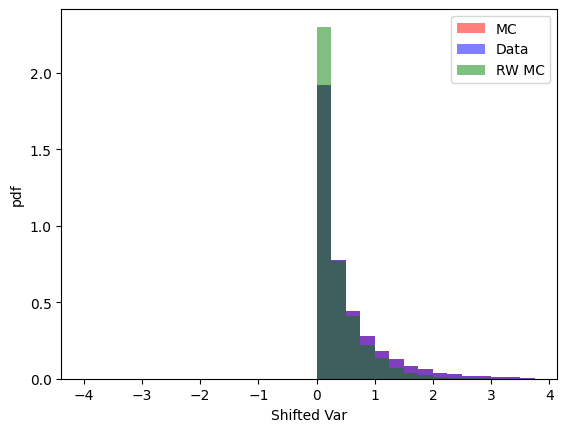

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))


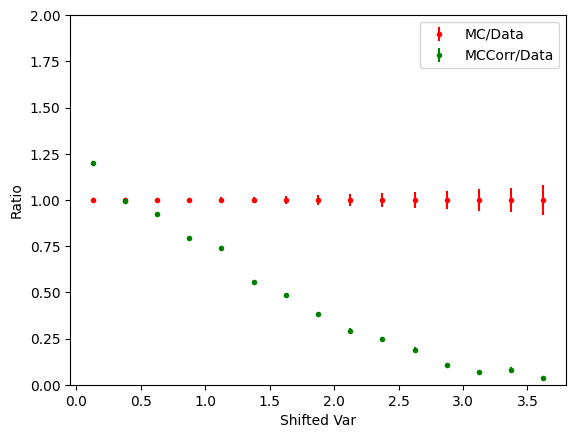

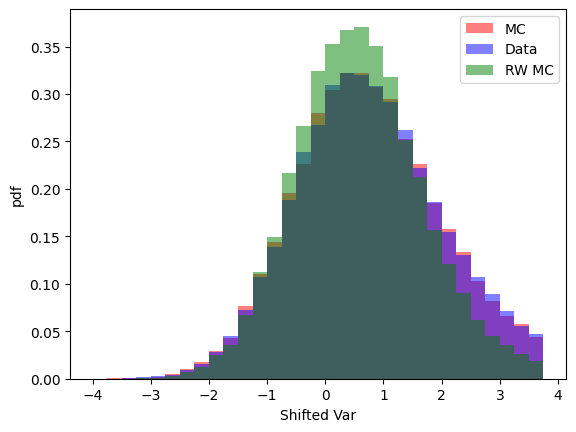

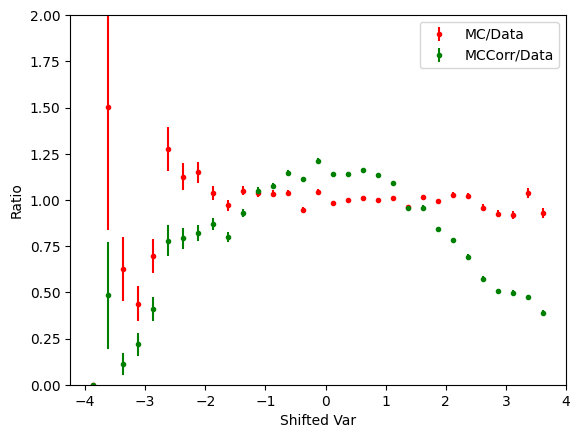

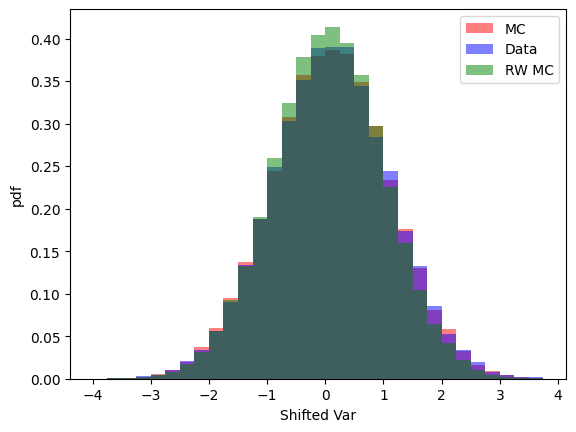

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: divide by zero encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))


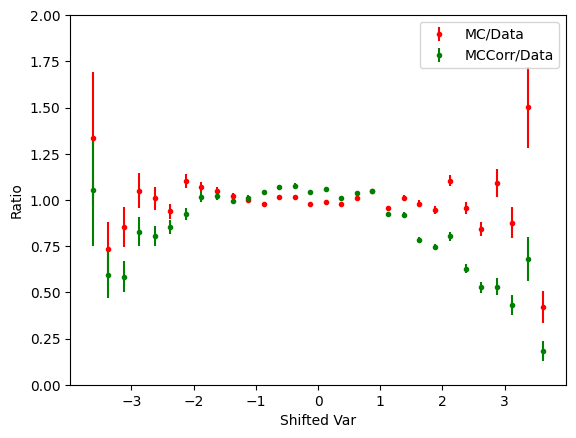

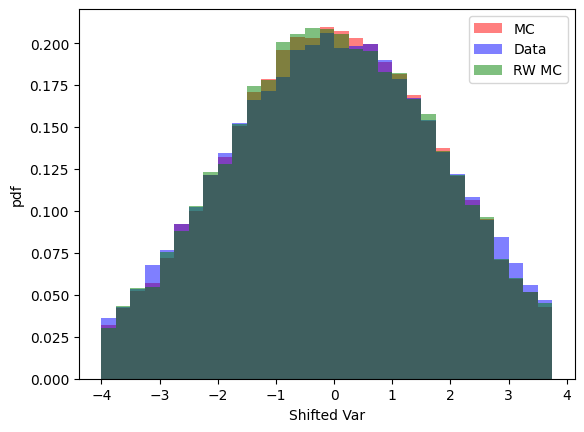

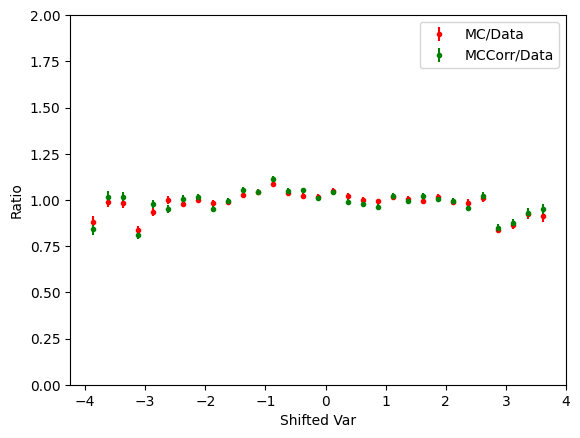

In [69]:
rw_model = simple_MLP_onelayer(datacontrol,5,out_channels=1,act_out=True,batchnorm=False)
rw_model.training_mse()

data_test,test_in,label_in=makeDataSet(iControl=False)
output=rw_model.forward(test_in)
weight=(output/(1-output)).detach().numpy()

weightedComp(test_in[:,1][label_in==1],test_in[:,1][label_in==0],weight[label_in==0])
weightedComp(test_in[:,2][label_in==1],test_in[:,2][label_in==0],weight[label_in==0])
weightedComp(test_in[:,3][label_in==1],test_in[:,3][label_in==0],weight[label_in==0])

data_conserved=data_train[:,3]-data_train[:,2]-data_train[:,1]
mc_conserved=mc_train[:,3]-mc_train[:,2]-mc_train[:,1]
weightedComp(data_conserved,mc_conserved,weight[label_in==0])


/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bkg_train_var = torch.tensor(self.bkg_train[currentVar],dtype=torch.float32,device=device)


Training flow bkgFlow_step0_0


Loss: 1.8854401588439942, p = 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.69it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step0_0


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step1_1


Loss: 0.2053569184243679, p = 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.13it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step1_1


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step2_2


Loss: 0.6032220301032066, p = 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step2_2


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step3_3


Loss: 1.4461556339263917, p = 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step3_3


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Training flow bkgFlow_step4_4


Loss: 1.315185191631317, p = 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]
/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train_var = torch.tensor(self.data_train[currentVar],dtype=torch.float32,device=device)


Training flow dataFlow_step4_4


  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:514: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(bkg_train_var[i],dtype=torch.float32,device=device)
  0%|                                                                                                                                                                         | 0/6 [00:00<?, ?it/s]/Users/philipharris/Dropbox/Physics/Contrast/quantile/quantiledatamc/toy/chainedMorpher.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

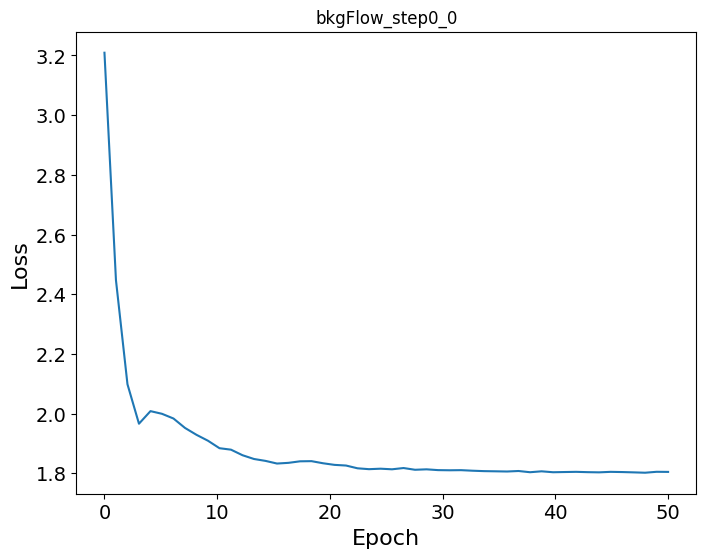

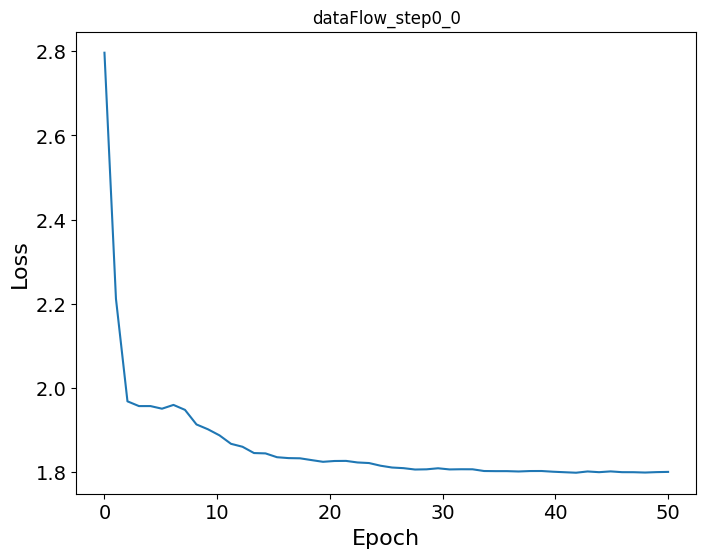

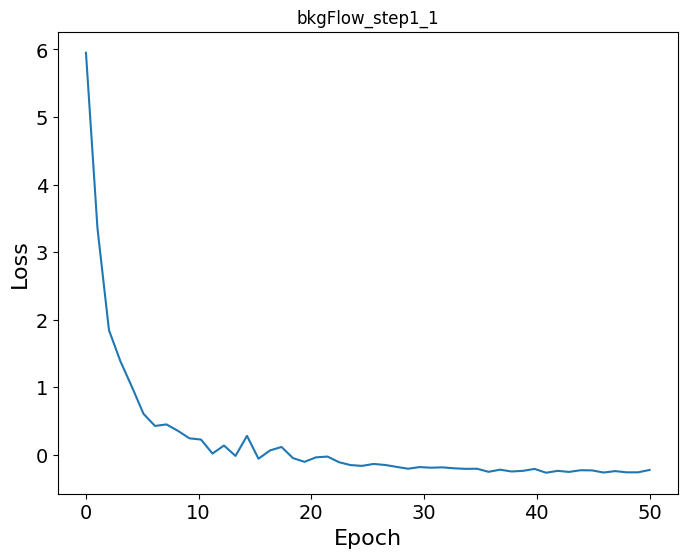

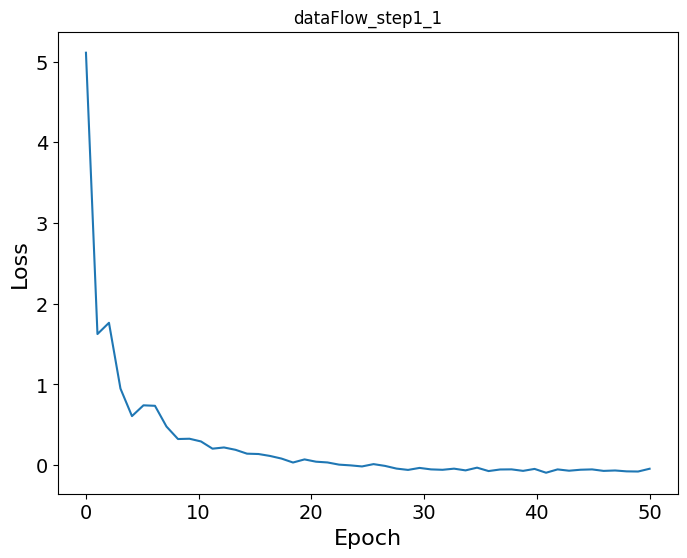

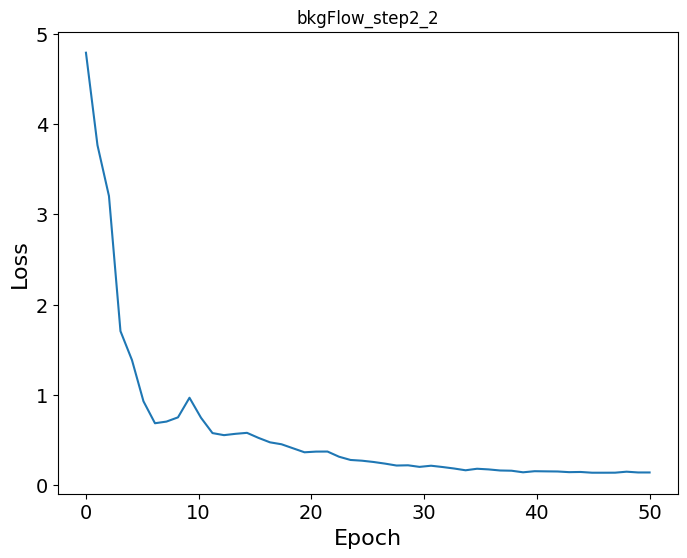

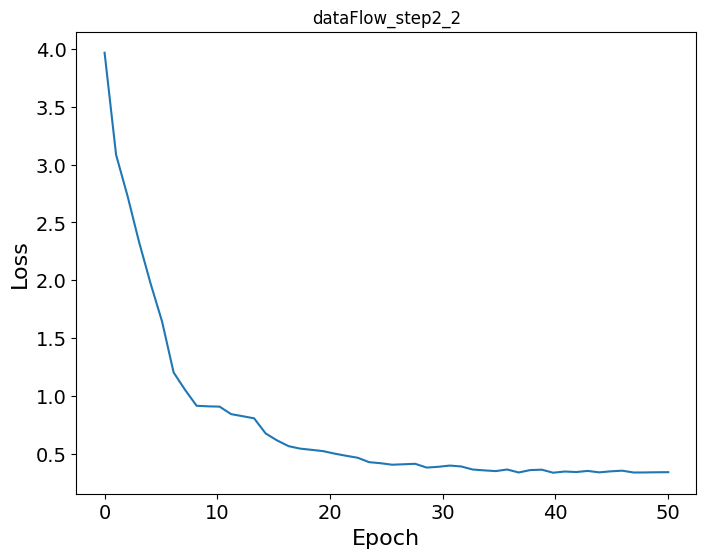

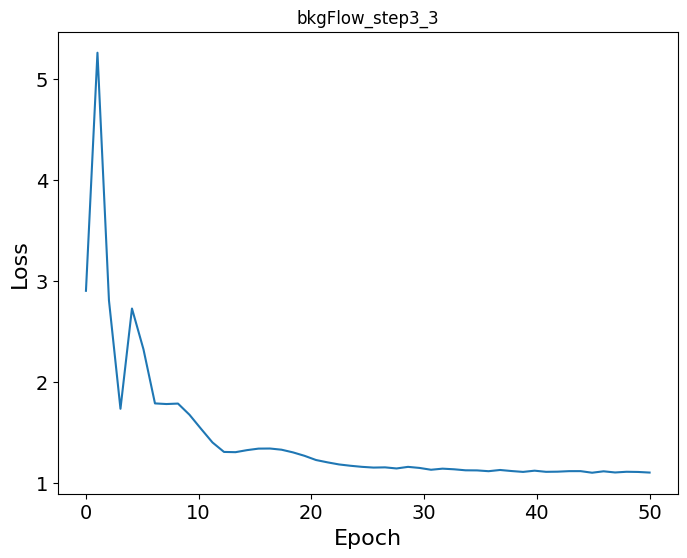

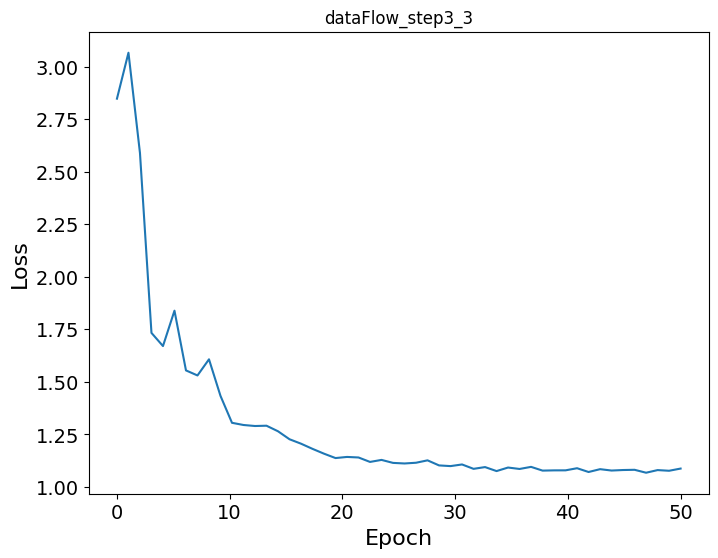

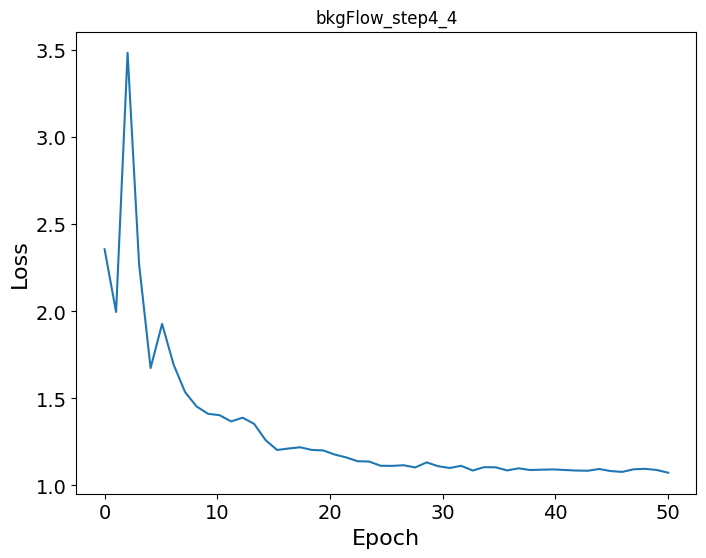

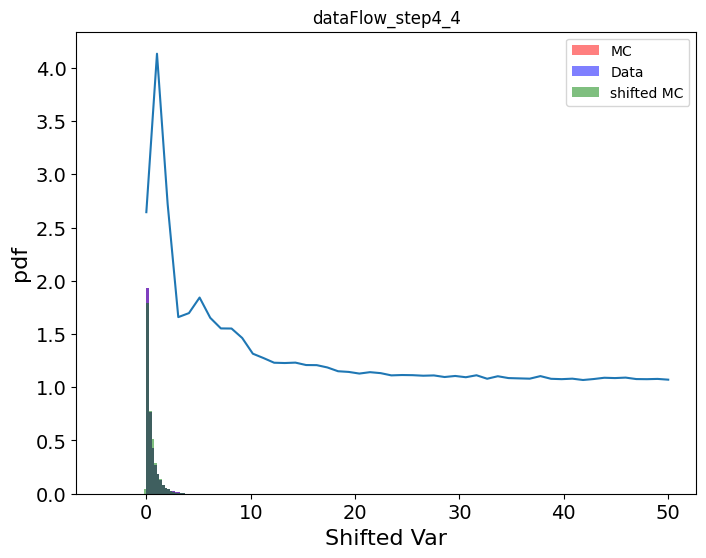

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))
/Users/philipharris/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3607: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


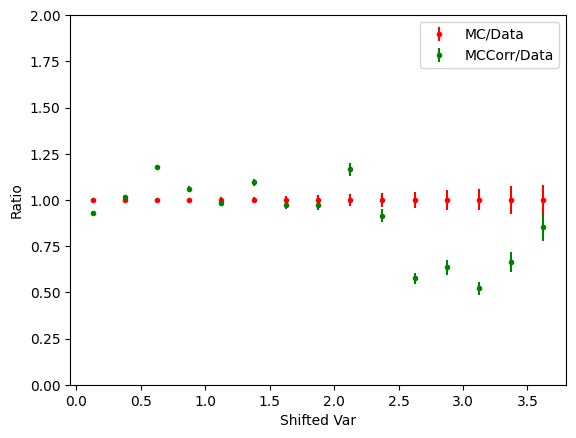

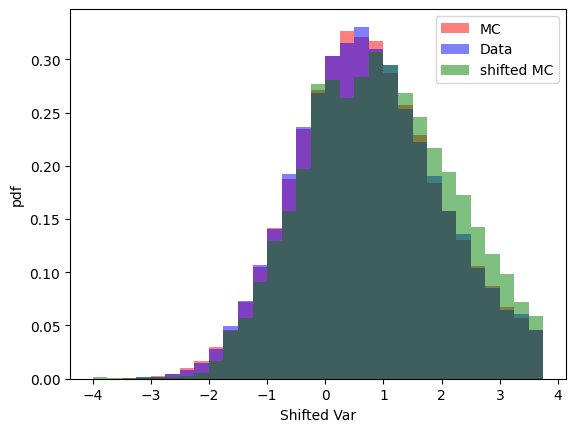

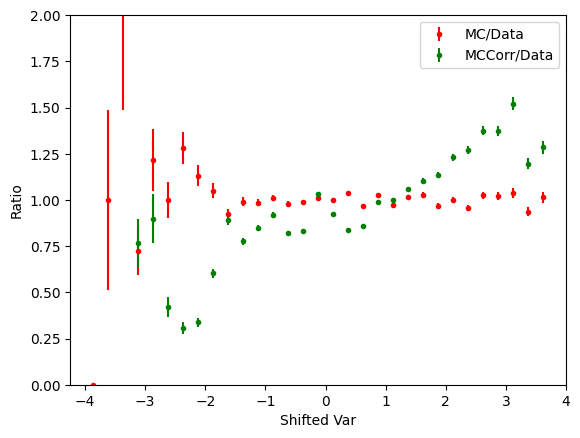

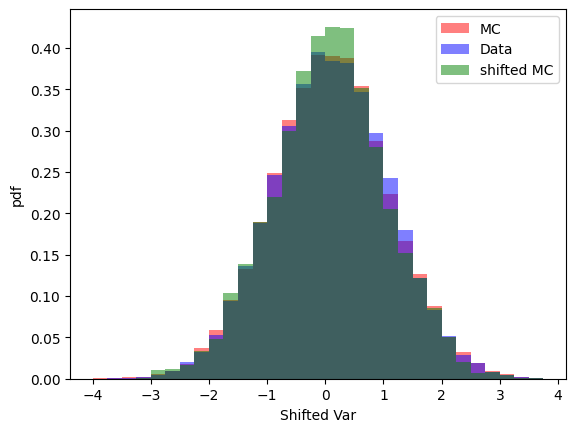

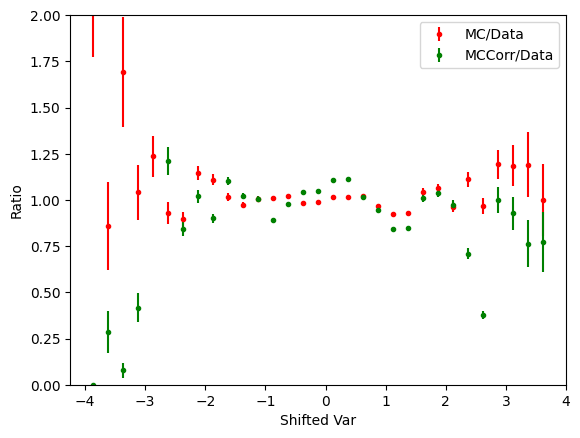

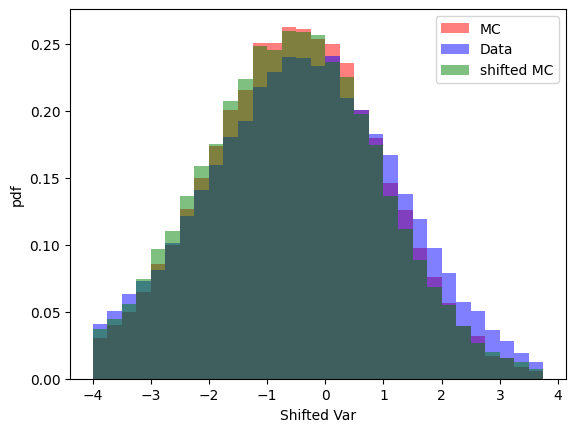

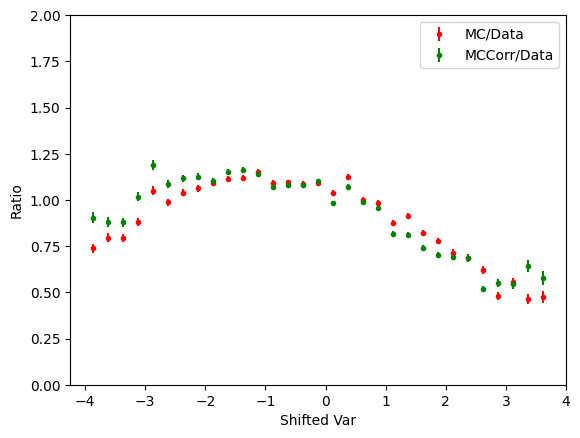

In [70]:
alldata_train,train_in,labeltrain_in=makeDataSet()
alldata_test,test_in,label_in  =makeDataSet()
mc_train  =train_in[0:50000]
mc_test   =test_in[0:50000]
data_train=train_in[50000::]
data_test =test_in [50000::]
trainer=trainflows(mc_train,mc_test,data_train,data_test,iNLayers=3,iSeparateScale=False)
alldata_test2,test2_in,labeltest2_in=makeDataSet(iControl=False)
mc_train  =test2_in[0:50000]
data_train=test2_in[50000::]
mccorr_train=trainer.correctFull(mc_train)
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,3],mc_train[:,3],mccorr_train['3'])
data_conserved=data_train[:,1]-data_train[:,3]-data_train[:,2]
mc_conserved=mc_train[:,1]-mc_train[:,3]-mc_train[:,2]
mccorr_conserved=mccorr_train['1']-mccorr_train['3']-mccorr_train['2']
quantileComp(data_conserved,mc_conserved,mccorr_conserved,)

Need to clen up plots, but not looking perfect, not sure why

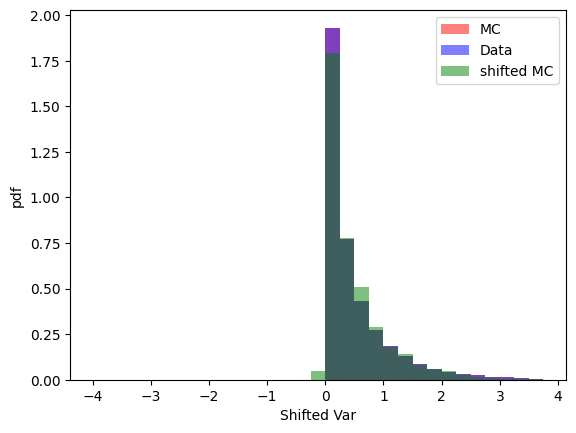

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:10: RuntimeWarning: invalid value encountered in divide
  ratio1=iMC/iData;     err1=np.sqrt((ratio1**2/iMC)+(ratio1**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_55050/1245574515.py:11: RuntimeWarning: invalid value encountered in divide
  ratio2=iMCCorr/iData; err2=np.sqrt((ratio2**2/iMCCorr)+(ratio2**2/iData))


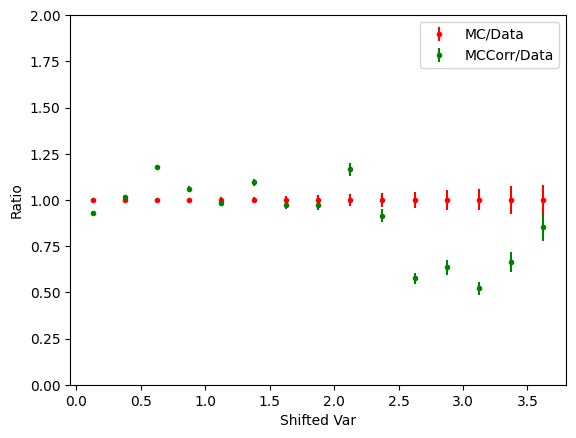

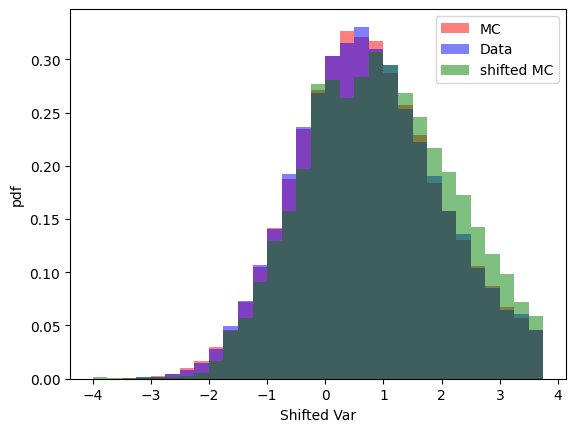

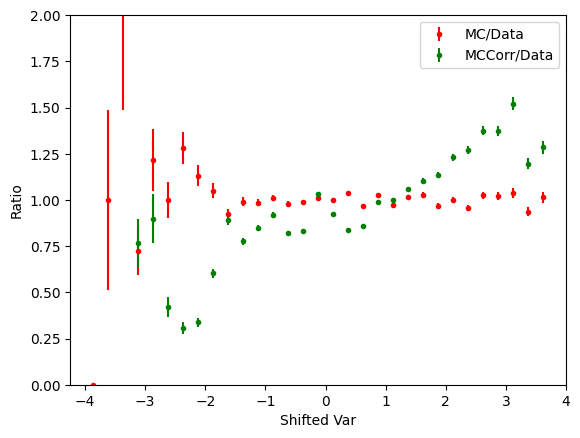

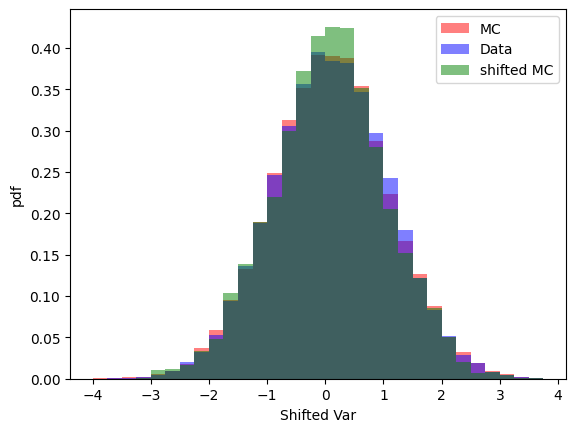

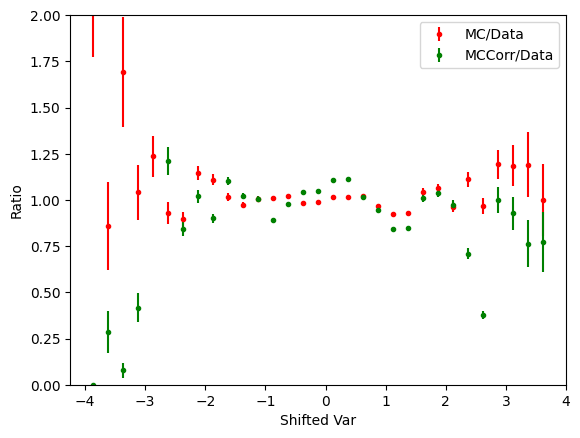

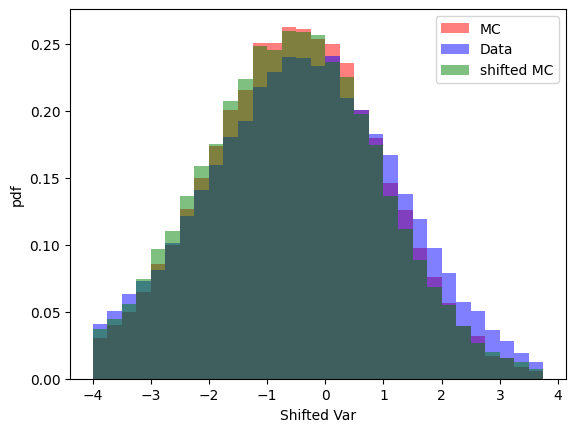

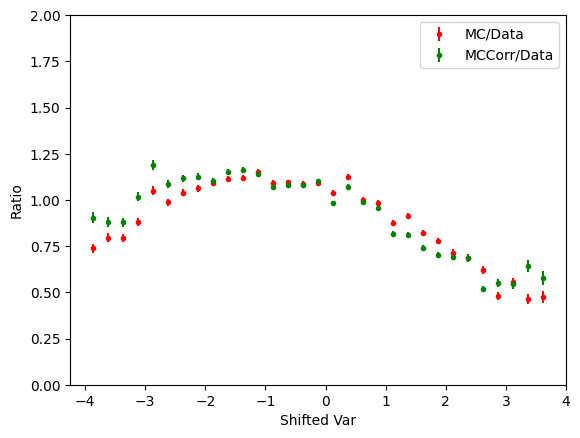

In [71]:
quantileComp(data_train[:,1],mc_train[:,1],mccorr_train['1'])
quantileComp(data_train[:,2],mc_train[:,2],mccorr_train['2'])
quantileComp(data_train[:,3],mc_train[:,3],mccorr_train['3'])
data_conserved=data_train[:,1]-data_train[:,3]-data_train[:,2]
mc_conserved=mc_train[:,1]-mc_train[:,3]-mc_train[:,2]
mccorr_conserved=mccorr_train['1']-mccorr_train['3']-mccorr_train['2']
quantileComp(data_conserved,mc_conserved,mccorr_conserved,)